In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from config import get_config
import torch
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
from torchvision import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ptflops as ptf
import os

In [25]:
model_config, data_config = get_config()

In [26]:
trainer = TrainMultiInputModel(model_config,data_config)
#trainer.train_and_validate()

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...


In [27]:
trainer.device

'cuda'

In [28]:
model_recto = model_config['model_recto']
model_verso =   model_config['model_verso']            
model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=False, num_classes=7)
checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_EfficientNet_model_verso_VGG_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
print('Loading trained model weights...')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(trainer.device)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...


In [40]:
def input_constructor(input_res):
    recto = torch.ones(()).new_empty((1, *input_res),
                                             device=trainer.device) 
    verso = torch.ones(()).new_empty((1, *input_res),
                                             device=trainer.device)
    return {"two_views": [recto,verso]}
            
with torch.cuda.device(0):
  net = model
  macs, params = ptf.get_model_complexity_info(net, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True,input_constructor = input_constructor)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Warning! No positional inputs found for a module, assuming batch size is 1.
MultiInputModel(
  17.93 k, 100.000% Params, 17.79 GMac, 100.000% MACs, 
  (modelRecto): EfficientNet(
    0, 0.000% Params, 2.41 GMac, 13.551% MACs, 
    (features): Sequential(
      0, 0.000% Params, 2.41 GMac, 13.551% MACs, 
      (0): Conv2dNormActivation(
        0, 0.000% Params, 17.46 MMac, 0.098% MACs, 
        (0): Conv2d(0, 0.000% Params, 16.26 MMac, 0.091% MACs, 3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(0, 0.000% Params, 1.2 MMac, 0.007% MACs, 48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
      )
      (1): Sequential(
        0, 0.000% Params, 45.16 MMac, 0.254% MACs, 
        (0): MBConv(
          0, 0.000% Params, 22.28 MMac, 0.125% MACs, 
          (block): Sequential(
            0, 0.000% Params, 22.28 MMac, 0.125% MACs, 
            (0): Conv2dNo

### Train and test shape by class

In [13]:
class_train = []
for i, (recto,verso) in tqdm(enumerate(zip(trainer.trainRectoloader,trainer.trainVersoloader)), total=len(trainer.trainVersoloader)):
        image_recto, labels = recto
        class_train.append(labels.tolist())
from collections import Counter
counter_class = Counter([item for sublist in class_train for item in sublist])
print(counter_class)

100%|██████████| 47/47 [00:22<00:00,  2.06it/s]

Counter({0: 255, 3: 218, 4: 212, 6: 211, 2: 206, 5: 206, 1: 165})


In [27]:
list(map(lambda x : x[1]/1473*100,sorted(counter_class.items())))

[17.311608961303463,
 11.201629327902241,
 13.985064494229462,
 14.799728445349627,
 14.392396469789546,
 13.985064494229462,
 14.324507807196198]

In [14]:
class_valid = []
for i, (recto,verso) in tqdm(enumerate(zip(trainer.validRectoloader,trainer.validVersoloader)), total=len(trainer.validVersoloader)):
        image_recto, labels = recto
        class_valid.append(labels.tolist())
from collections import Counter
counter_class_v = Counter([item for sublist in class_valid for item in sublist])
print(counter_class_v)

100%|██████████| 12/12 [00:05<00:00,  2.06it/s]

Counter({0: 69, 6: 62, 3: 62, 4: 50, 1: 44, 2: 41, 5: 40})


In [29]:
list(map(lambda x : x[1]/368*100,sorted(counter_class_v.items())))

[18.75,
 11.956521739130435,
 11.141304347826086,
 16.847826086956523,
 13.586956521739129,
 10.869565217391305,
 16.847826086956523]

In [30]:
class_test = []
for i, (recto,verso) in tqdm(enumerate(zip(trainer.testRectoloader,trainer.testVersoloader)), total=len(trainer.testVersoloader)):
        image_recto, labels = recto
        class_test.append(labels.tolist())
from collections import Counter
counter_class_t = Counter([item for sublist in class_test for item in sublist])
print(counter_class_t)
print(list(map(lambda x : x[1]/368*100,sorted(counter_class_t.items()))))


100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

Counter({6: 84, 5: 71, 0: 70, 3: 67, 2: 63, 1: 57, 4: 48})
[19.021739130434785, 15.489130434782608, 17.119565217391305, 18.206521739130434, 13.043478260869565, 19.293478260869566, 22.82608695652174]


## Model Evaluation EfficientNet + VGG16 

In [7]:
from torch.nn import functional as F
model.eval()
with torch.no_grad():
    counter=0
    outputs_test_preds= []
    outputs_test_probs = []
    real_labels = []
    for i, (recto,verso) in tqdm(enumerate(zip(trainer.testRectoloader,trainer.testVersoloader)), total=len(trainer.testVersoloader)):
        counter += 1
        image_recto, labels = recto
        image_recto = image_recto.to(trainer.device)
        labels = labels.to(trainer.device)
        image_verso, _ = verso
        image_verso = image_verso.to(trainer.device)
        # Forward pass.
        outputs_test = model([image_recto,image_verso])
        outputs_test_prob = F.softmax(outputs_test,dim=1)
        probs , preds = torch.max(outputs_test_prob.data, 1)
        real_labels.append(labels.tolist())
        outputs_test_preds.append(preds.tolist())
        outputs_test_probs.append(probs.tolist())

100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


In [8]:
outputs_test_preds = [item for sublist in outputs_test_preds for item in sublist]
outputs_test_probs = [item for sublist in outputs_test_probs for item in sublist]
real_labels = [item for sublist in real_labels for item in sublist]

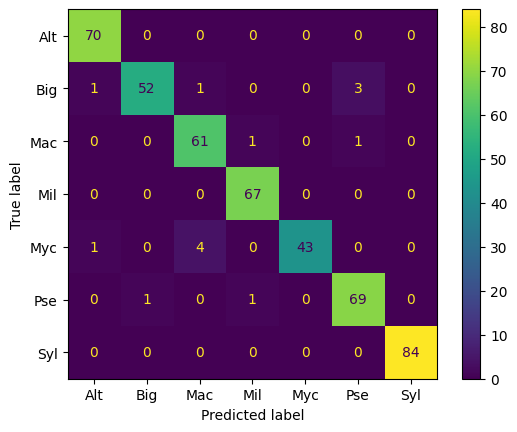

Accuracy : 0.9695652173913043
Balanced Accuracy : 0.9640284270367401


In [9]:
y_pred=outputs_test_preds
y_obs=real_labels
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))

## Show Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


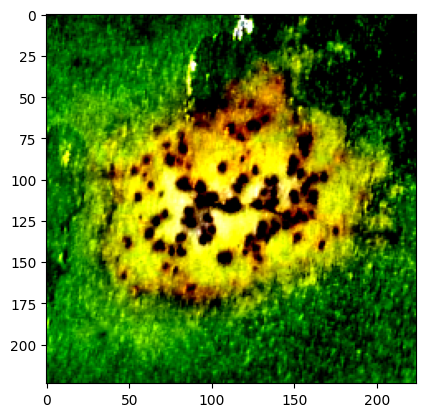

Label: ['Mac']
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


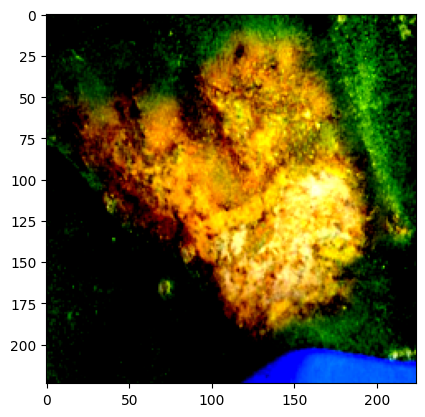

Label: ['Mil']
2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


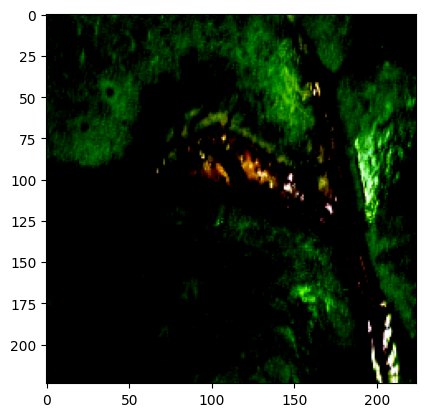

Label: ['Mac']
3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


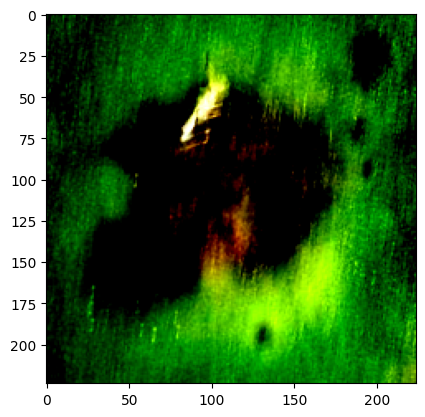

Label: ['Big']
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


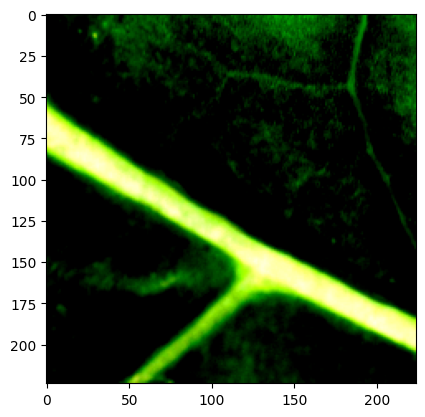

Label: ['Syl']
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


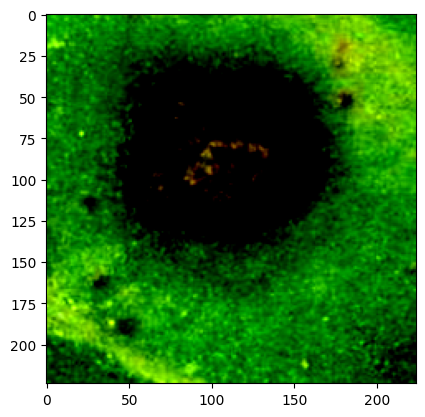

Label: ['Alt']
6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


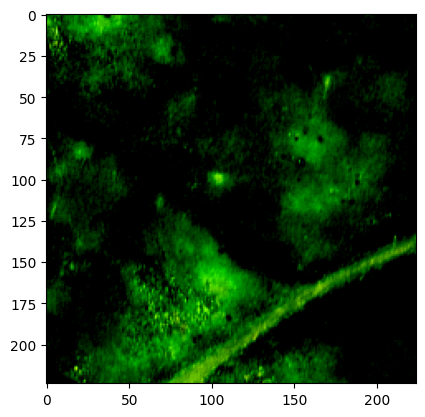

Label: ['Syl']
7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


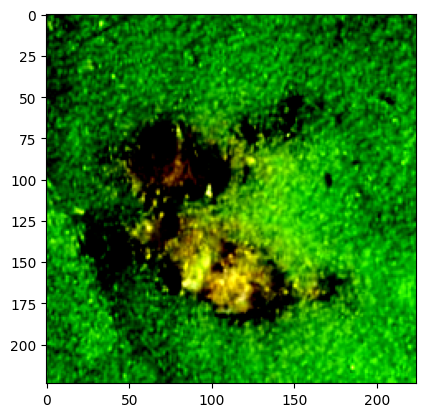

Label: ['Mil']
8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


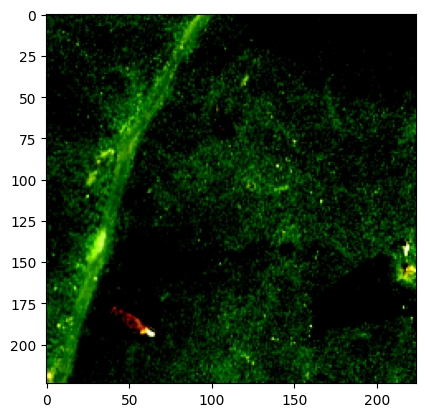

Label: ['Syl']
9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


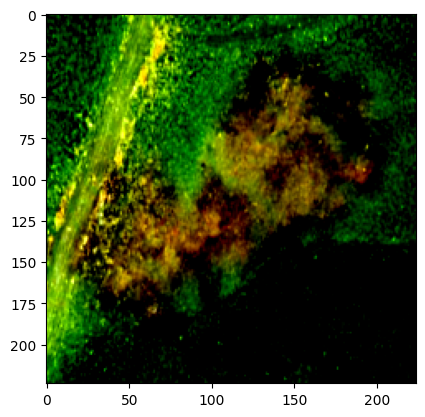

Label: ['Mil']
10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


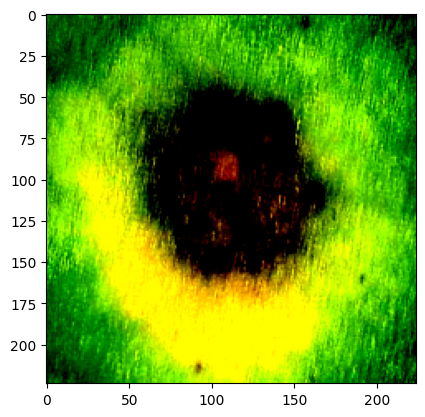

Label: ['Big']
11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


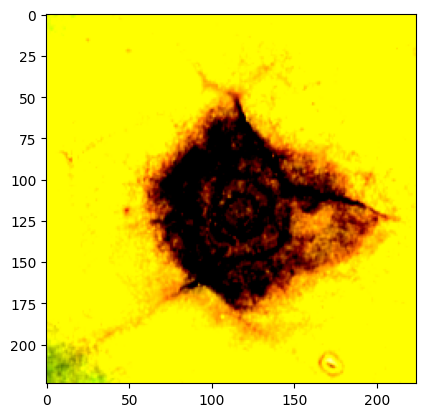

Label: ['Alt']
12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


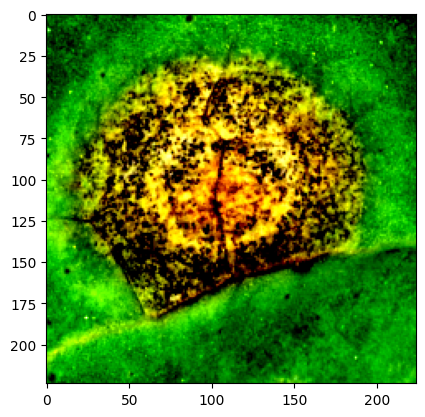

Label: ['Myc']
13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


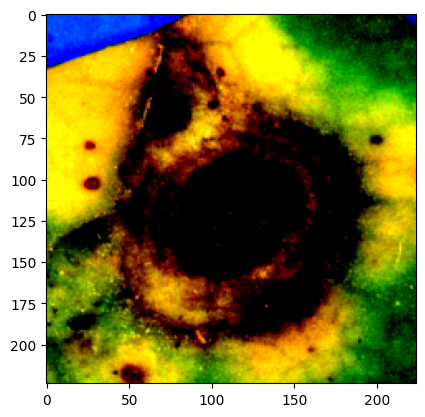

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: ['Alt']
14


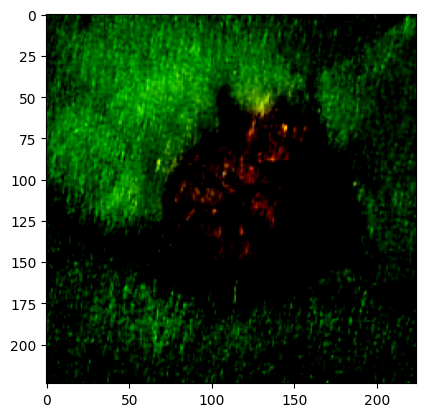

Label: ['Big']
15


In [28]:
i=0
for i,recto  in enumerate(trainer.testRectoloader):
    image_recto, labels = recto
    plt.imshow(np.transpose(image_recto[0].cpu().detach().numpy(), (1, 2, 0)))
    plt.show()
    print(f"Label: {le.inverse_transform([labels[0]])}")
    i=i+1
    print(i)

## Retrieve path to image

In [30]:
datasetRecto_test_datafolder = datasets.ImageFolder(
           trainer.loader.root_dir +'RECTO', 
            #transform=(self.get_test_transform())
        )

In [31]:
report = {'image_path_recto':[],
          'real':real_labels,
          'pred':outputs_test_preds
         }
indices = trainer.datasetRecto_test.indices
for ind in indices:
    report['image_path_recto'].append(datasetRecto_test_datafolder.samples[ind][0])

df_image_compare = pd.DataFrame(report)

In [32]:
df_image_compare.shape

(460, 3)

In [33]:
df_differ = df_image_compare[df_image_compare['real']!=df_image_compare['pred']]

In [34]:
df_differ.reset_index(inplace=True)

In [35]:
df_differ.shape

(14, 4)

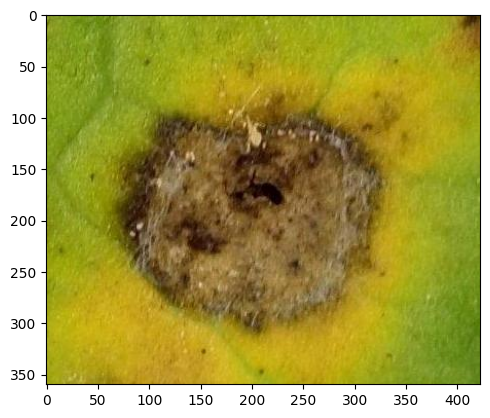

Prédiction : ['Syl']
Annoté : ['Myc']
------------------------------------------
------------------------------------------


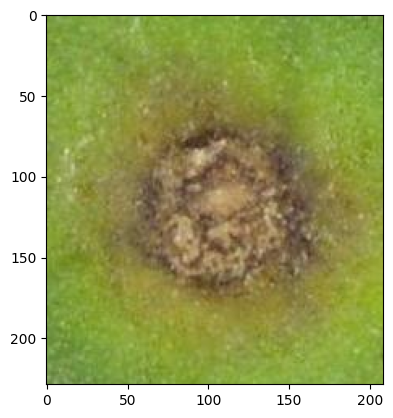

Prédiction : ['Syl']
Annoté : ['Mac']
------------------------------------------
------------------------------------------


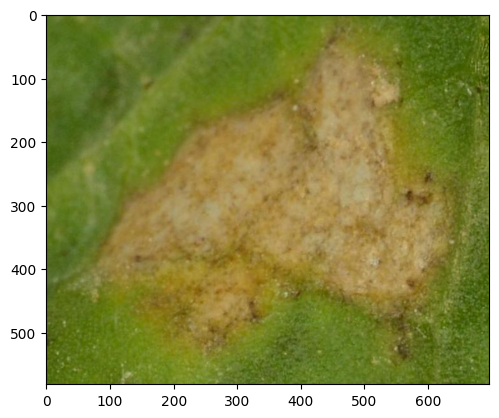

Prédiction : ['Pse']
Annoté : ['Big']
------------------------------------------
------------------------------------------


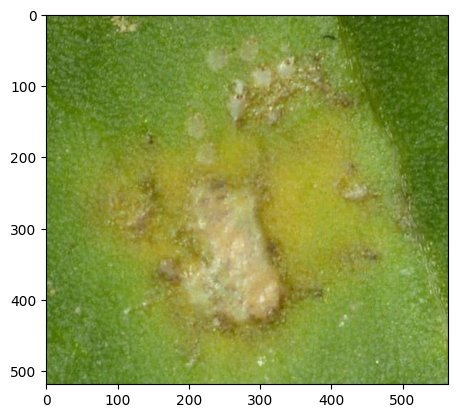

Prédiction : ['Myc']
Annoté : ['Alt']
------------------------------------------
------------------------------------------


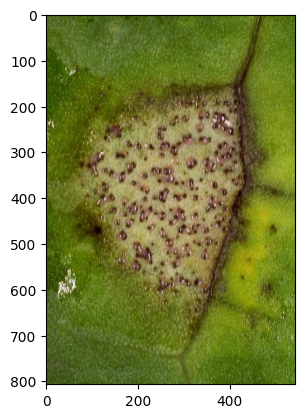

Prédiction : ['Pse']
Annoté : ['Mac']
------------------------------------------
------------------------------------------


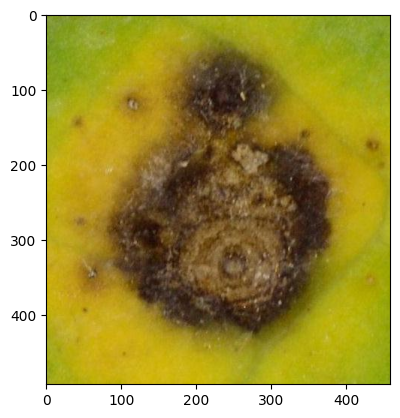

Prédiction : ['Mac']
Annoté : ['Big']
------------------------------------------
------------------------------------------


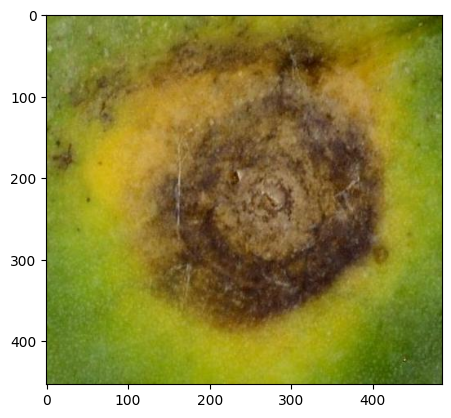

Prédiction : ['Pse']
Annoté : ['Big']
------------------------------------------
------------------------------------------


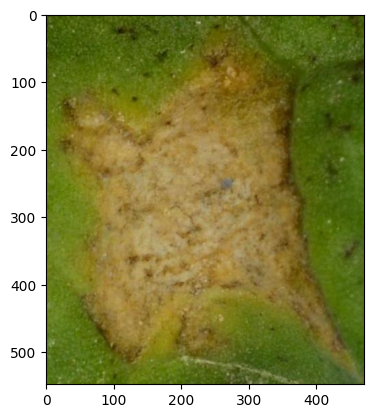

Prédiction : ['Big']
Annoté : ['Pse']
------------------------------------------
------------------------------------------


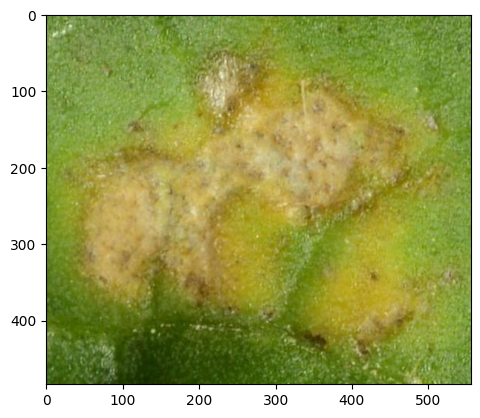

Prédiction : ['Alt']
Annoté : ['Big']
------------------------------------------
------------------------------------------


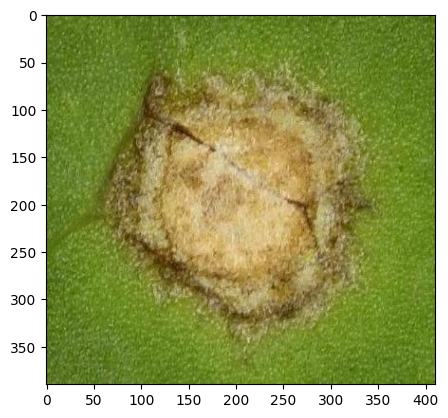

Prédiction : ['Alt']
Annoté : ['Big']
------------------------------------------
------------------------------------------


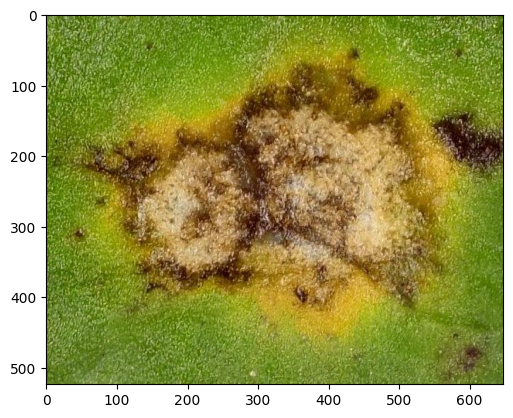

Prédiction : ['Mac']
Annoté : ['Pse']
------------------------------------------
------------------------------------------


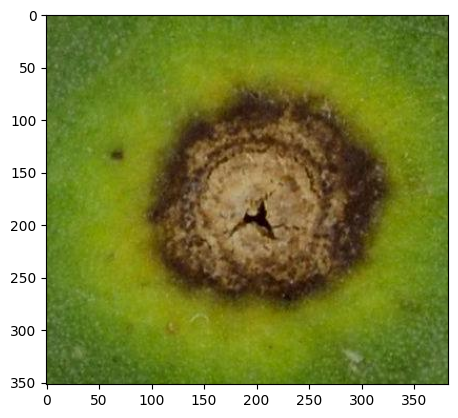

Prédiction : ['Big']
Annoté : ['Pse']
------------------------------------------
------------------------------------------


In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for index,row in df_differ.iterrows():
    path = row['image_path_recto']
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.show()
    pred = le.inverse_transform([row['pred']])
    real = le.inverse_transform([row['real']])
    print(f'Prédiction : {pred}')
    print(f'Annoté : {real}')
    print("------------------------------------------")
    print("------------------------------------------")

## Test multiple models combinations

In [98]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

def modified_resnet(model):
    model.fc = Identity()
    return model

def modified_densenet(model):
    model.classifier = Identity()
    return model 

In [99]:
models = [{'model':torchvision.models.efficientnet_b5(weights='IMAGENET1K_V1'),
                                      'avgpool':torch.nn.AdaptiveAvgPool2d(1),
                                      'last_layer_size':2048,
                                      'model_name' : 'EfficientNet',
                                       'features' : None
          },
          {'model':torchvision.models.densenet121(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':1024,
                                  'model_name' : 'DenseNet121',
                                   'features' : modified_densenet(torchvision.models.densenet121(weights='IMAGENET1K_V1')),
            },
          {'model':torchvision.models.resnet50(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet50',
                                   'features' : modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))
            },
          {'model':torchvision.models.vgg16(weights='IMAGENET1K_V1'),
                                  'avgpool':torch.nn.AdaptiveAvgPool2d((1,1)),
                                  'last_layer_size':512,
                                  'model_name' : 'VGG',
                                   'features' : None
            },
          
          {'model':torchvision.models.resnet152(weights='IMAGENET1K_V1'),
                                  'avgpool':None,
                                  'last_layer_size':2048,
                                  'model_name' : 'ResNet152',
                                   'features' : modified_resnet(torchvision.models.resnet152(weights='IMAGENET1K_V1'))
            }
          
]

In [60]:
torchvision.models.densenet121(weights='IMAGENET1K_V1')

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [55]:
x =torch.ones((1,3,224,224))
modified_resnet(torchvision.models.resnet50(weights='IMAGENET1K_V1'))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

148,755,079 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.006, training acc: 72.098
Validation loss: 0.486, validation acc: 88.859
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.376, training acc: 91.853
Validation loss: 0.292, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.275, training acc: 94.094
Validation loss: 0.226, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.243, training acc: 95.248
Validation loss: 0.207, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.224, training acc: 95.587
Validation loss: 0.201, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.192, training acc: 95.791
Validation loss: 0.191, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.174, training acc: 96.877
Validation loss: 0.200, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.164, training acc: 97.149
Validation loss: 0.190, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.143, training acc: 97.488
Validation loss: 0.172, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.760
Validation loss: 0.172, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.127, training acc: 97.624
Validation loss: 0.169, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.102, training acc: 98.710
Validation loss: 0.177, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.076, training acc: 98.846
Validation loss: 0.165, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.075, training acc: 98.914
Validation loss: 0.164, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.077, training acc: 98.846
Validation loss: 0.150, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.077, training acc: 98.642
Validation loss: 0.154, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.062, training acc: 99.253
Validation loss: 0.146, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.058, training acc: 98.982
Validation loss: 0.156, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.051, training acc: 99.185
Validation loss: 0.142, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.043, training acc: 99.525
Validation loss: 0.139, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.038, training acc: 99.389
Validation loss: 0.145, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.042, training acc: 99.593
Validation loss: 0.161, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.038, training acc: 99.593
Validation loss: 0.156, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.036, training acc: 99.661
Validation loss: 0.146, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.039, training acc: 99.185
Validation loss: 0.154, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.030, training acc: 99.864
Validation loss: 0.151, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.028, training acc: 99.661
Validation loss: 0.145, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.027, training acc: 99.389
Validation loss: 0.159, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.021, training acc: 99.728
Validation loss: 0.153, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.023, training acc: 99.661
Validation loss: 0.158, validation acc: 94.293
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

45,344,007 total parameters.
21,511 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.129, training acc: 71.419
Validation loss: 0.616, validation acc: 84.511
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.451, training acc: 91.989
Validation loss: 0.394, validation acc: 89.946
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.310, training acc: 95.180
Validation loss: 0.314, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.274, training acc: 96.062
Validation loss: 0.275, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.219, training acc: 96.673
Validation loss: 0.242, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 97.217
Validation loss: 0.230, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.180, training acc: 97.284
Validation loss: 0.213, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.149, training acc: 97.828
Validation loss: 0.203, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.134, training acc: 97.760
Validation loss: 0.204, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.135, training acc: 98.099
Validation loss: 0.187, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.118, training acc: 98.506
Validation loss: 0.176, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.111, training acc: 98.099
Validation loss: 0.175, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.095, training acc: 98.439
Validation loss: 0.170, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.080, training acc: 98.914
Validation loss: 0.165, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.086, training acc: 99.117
Validation loss: 0.166, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.094, training acc: 99.117
Validation loss: 0.164, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.080, training acc: 98.778
Validation loss: 0.167, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 99.321
Validation loss: 0.158, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.056, training acc: 99.321
Validation loss: 0.156, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.052, training acc: 99.661
Validation loss: 0.151, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.052, training acc: 99.457
Validation loss: 0.148, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.050, training acc: 99.525
Validation loss: 0.148, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Training loss: 0.053, training acc: 99.321
Validation loss: 0.149, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.043, training acc: 99.457
Validation loss: 0.143, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.043, training acc: 99.593
Validation loss: 0.148, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.044, training acc: 99.525
Validation loss: 0.141, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.042, training acc: 99.525
Validation loss: 0.144, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.038, training acc: 99.728
Validation loss: 0.143, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.037, training acc: 99.593
Validation loss: 0.144, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.031, training acc: 99.728
Validation loss: 0.142, validation acc: 93.750
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

14,947,055 total parameters.
14,343 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.165, training acc: 65.309
Validation loss: 0.547, validation acc: 88.043
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.507, training acc: 88.595
Validation loss: 0.391, validation acc: 88.043
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.369, training acc: 91.921
Validation loss: 0.331, validation acc: 89.402
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.302, training acc: 93.347
Validation loss: 0.291, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.266, training acc: 94.433
Validation loss: 0.266, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.273, training acc: 94.840
Validation loss: 0.249, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.241, training acc: 95.112
Validation loss: 0.244, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.220, training acc: 95.927
Validation loss: 0.245, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 96.741
Validation loss: 0.225, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.190, training acc: 96.402
Validation loss: 0.213, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.182, training acc: 96.266
Validation loss: 0.219, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.170, training acc: 96.673
Validation loss: 0.216, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.163, training acc: 96.130
Validation loss: 0.221, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.146, training acc: 97.013
Validation loss: 0.195, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.138, training acc: 97.352
Validation loss: 0.184, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.149, training acc: 97.217
Validation loss: 0.181, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.124, training acc: 97.963
Validation loss: 0.175, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.132, training acc: 97.352
Validation loss: 0.205, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.013
Validation loss: 0.180, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.132, training acc: 97.692
Validation loss: 0.187, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.136, training acc: 98.235
Validation loss: 0.168, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 96.606
Validation loss: 0.184, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.110, training acc: 98.099
Validation loss: 0.203, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.129, training acc: 97.284
Validation loss: 0.202, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.093, training acc: 97.692
Validation loss: 0.190, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.069, training acc: 99.117
Validation loss: 0.183, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.073, training acc: 98.303
Validation loss: 0.163, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.070, training acc: 98.846
Validation loss: 0.164, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.071, training acc: 98.642
Validation loss: 0.183, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.063, training acc: 98.914
Validation loss: 0.178, validation acc: 95.109
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

64,019,287 total parameters.
21,511 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.090, training acc: 66.667
Validation loss: 0.451, validation acc: 87.772
--------------------------------------------------
Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.476, training acc: 88.527
Validation loss: 0.284, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.327, training acc: 93.007
Validation loss: 0.242, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.277, training acc: 93.483
Validation loss: 0.215, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.231, training acc: 95.384
Validation loss: 0.185, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.207, training acc: 95.723
Validation loss: 0.176, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.187, training acc: 96.062
Validation loss: 0.170, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.196, training acc: 95.995
Validation loss: 0.152, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 95.927
Validation loss: 0.151, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.182, training acc: 96.538
Validation loss: 0.147, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.189, training acc: 95.859
Validation loss: 0.145, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.164, training acc: 96.130
Validation loss: 0.144, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.160, training acc: 96.538
Validation loss: 0.142, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.167, training acc: 96.470
Validation loss: 0.140, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.177, training acc: 96.538
Validation loss: 0.144, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.144, training acc: 96.538
Validation loss: 0.143, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.141, training acc: 96.877
Validation loss: 0.153, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.150, training acc: 97.217
Validation loss: 0.151, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.137, training acc: 96.673
Validation loss: 0.135, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.117, training acc: 97.556
Validation loss: 0.145, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.114, training acc: 97.963
Validation loss: 0.163, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 96.945
Validation loss: 0.143, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.106, training acc: 97.895
Validation loss: 0.139, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.120, training acc: 97.352
Validation loss: 0.138, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.110, training acc: 96.266
Validation loss: 0.122, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.073, training acc: 98.235
Validation loss: 0.124, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.052, training acc: 98.982
Validation loss: 0.128, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.052, training acc: 99.050
Validation loss: 0.139, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.055, training acc: 98.642
Validation loss: 0.125, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 98.574
Validation loss: 0.133, validation acc: 94.837
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

153,301,015 total parameters.
10,759 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.256, training acc: 62.118
Validation loss: 0.727, validation acc: 81.793
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.577, training acc: 88.391
Validation loss: 0.483, validation acc: 88.043
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.405, training acc: 92.261
Validation loss: 0.395, validation acc: 90.217
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.338, training acc: 93.075
Validation loss: 0.340, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.284, training acc: 94.569
Validation loss: 0.310, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.240, training acc: 94.705
Validation loss: 0.288, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.203, training acc: 95.791
Validation loss: 0.273, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 96.402
Validation loss: 0.256, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.177, training acc: 96.198
Validation loss: 0.244, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.163, training acc: 96.266
Validation loss: 0.240, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.142, training acc: 97.081
Validation loss: 0.221, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.132, training acc: 97.149
Validation loss: 0.217, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.131, training acc: 96.741
Validation loss: 0.221, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.118, training acc: 98.031
Validation loss: 0.206, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 97.556
Validation loss: 0.200, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.107, training acc: 97.895
Validation loss: 0.191, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.105, training acc: 97.895
Validation loss: 0.206, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.095, training acc: 98.099
Validation loss: 0.195, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.093, training acc: 97.828
Validation loss: 0.183, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.089, training acc: 98.235
Validation loss: 0.185, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.083, training acc: 98.031
Validation loss: 0.183, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.081, training acc: 97.963
Validation loss: 0.189, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.074, training acc: 98.506
Validation loss: 0.180, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.077, training acc: 98.371
Validation loss: 0.173, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.069, training acc: 98.371
Validation loss: 0.169, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.067, training acc: 98.778
Validation loss: 0.170, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.066, training acc: 98.574
Validation loss: 0.181, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.064, training acc: 98.914
Validation loss: 0.170, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.060, training acc: 98.574
Validation loss: 0.164, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.065, training acc: 98.574
Validation loss: 0.172, validation acc: 94.022
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

133,290,839 total parameters.
21,511 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.075, training acc: 67.617
Validation loss: 0.459, validation acc: 87.772
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.455, training acc: 89.070
Validation loss: 0.278, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.314, training acc: 92.736
Validation loss: 0.237, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.262, training acc: 93.686
Validation loss: 0.215, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.227, training acc: 94.433
Validation loss: 0.193, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.211, training acc: 95.112
Validation loss: 0.174, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.194, training acc: 95.180
Validation loss: 0.175, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.206, training acc: 96.198
Validation loss: 0.184, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.203, training acc: 95.384
Validation loss: 0.187, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.205, training acc: 95.587
Validation loss: 0.179, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.202, training acc: 95.587
Validation loss: 0.172, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.167, training acc: 96.470
Validation loss: 0.171, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.181, training acc: 96.402
Validation loss: 0.201, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.179, training acc: 96.130
Validation loss: 0.174, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.194, training acc: 96.266
Validation loss: 0.174, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.155, training acc: 96.877
Validation loss: 0.189, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.145, training acc: 97.149
Validation loss: 0.179, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.121, training acc: 97.624
Validation loss: 0.186, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.149
Validation loss: 0.193, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.108, training acc: 97.420
Validation loss: 0.159, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.101, training acc: 97.828
Validation loss: 0.197, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.102, training acc: 97.895
Validation loss: 0.170, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.107, training acc: 98.031
Validation loss: 0.180, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.149
Validation loss: 0.175, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.080, training acc: 97.963
Validation loss: 0.188, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.058, training acc: 98.506
Validation loss: 0.173, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.042, training acc: 99.050
Validation loss: 0.204, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.048, training acc: 98.982
Validation loss: 0.187, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 99.185
Validation loss: 0.164, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.060, training acc: 98.914
Validation loss: 0.162, validation acc: 95.109
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

79,483,527 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.995, training acc: 73.116
Validation loss: 0.423, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.387, training acc: 91.650
Validation loss: 0.326, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.276, training acc: 94.162
Validation loss: 0.275, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.229, training acc: 94.569
Validation loss: 0.223, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.196, training acc: 95.859
Validation loss: 0.213, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.192, training acc: 96.062
Validation loss: 0.188, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.172, training acc: 96.741
Validation loss: 0.184, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.134, training acc: 97.556
Validation loss: 0.180, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.120, training acc: 98.031
Validation loss: 0.181, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 98.167
Validation loss: 0.177, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 98.235
Validation loss: 0.164, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.106, training acc: 98.371
Validation loss: 0.156, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.100, training acc: 98.506
Validation loss: 0.194, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.982
Validation loss: 0.169, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.064, training acc: 99.389
Validation loss: 0.164, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.071, training acc: 99.253
Validation loss: 0.169, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 99.117
Validation loss: 0.174, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.051, training acc: 99.321
Validation loss: 0.172, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.044, training acc: 99.321
Validation loss: 0.154, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.037, training acc: 99.728
Validation loss: 0.158, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.035, training acc: 99.525
Validation loss: 0.161, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.042, training acc: 99.661
Validation loss: 0.145, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.046, training acc: 99.389
Validation loss: 0.172, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.033, training acc: 99.661
Validation loss: 0.153, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.027, training acc: 99.864
Validation loss: 0.136, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.029, training acc: 99.661
Validation loss: 0.152, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.032, training acc: 99.661
Validation loss: 0.160, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.025, training acc: 99.593
Validation loss: 0.138, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.027, training acc: 99.661
Validation loss: 0.148, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.023, training acc: 99.796
Validation loss: 0.149, validation acc: 95.380
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

64,019,287 total parameters.
21,511 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.074, training acc: 67.685
Validation loss: 0.425, validation acc: 90.217
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.444, training acc: 89.952
Validation loss: 0.276, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.304, training acc: 91.853
Validation loss: 0.246, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.238, training acc: 94.908
Validation loss: 0.208, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.207, training acc: 96.062
Validation loss: 0.196, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.215, training acc: 94.908
Validation loss: 0.187, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.190, training acc: 95.859
Validation loss: 0.173, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.181, training acc: 95.655
Validation loss: 0.174, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.155, training acc: 96.538
Validation loss: 0.158, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.156, training acc: 96.130
Validation loss: 0.159, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.163, training acc: 96.334
Validation loss: 0.169, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.180, training acc: 96.198
Validation loss: 0.200, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.160, training acc: 96.266
Validation loss: 0.199, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.182, training acc: 96.673
Validation loss: 0.187, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.153, training acc: 96.334
Validation loss: 0.173, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.167, training acc: 97.488
Validation loss: 0.182, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 97.556
Validation loss: 0.178, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.151, training acc: 96.673
Validation loss: 0.192, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.217
Validation loss: 0.162, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.116, training acc: 97.217
Validation loss: 0.184, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.124, training acc: 97.624
Validation loss: 0.172, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.110, training acc: 97.217
Validation loss: 0.181, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.139, training acc: 96.673
Validation loss: 0.177, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.116, training acc: 97.217
Validation loss: 0.202, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.096, training acc: 98.031
Validation loss: 0.191, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.099, training acc: 98.031
Validation loss: 0.179, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.090, training acc: 98.303
Validation loss: 0.181, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.080, training acc: 98.099
Validation loss: 0.184, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.071, training acc: 98.371
Validation loss: 0.204, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 98.642
Validation loss: 0.198, validation acc: 94.837
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

49,093,743 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.068, training acc: 67.142
Validation loss: 0.456, validation acc: 88.587
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.454, training acc: 89.002
Validation loss: 0.319, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.331, training acc: 91.718
Validation loss: 0.280, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.251, training acc: 93.686
Validation loss: 0.234, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.202, training acc: 94.637
Validation loss: 0.216, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.185, training acc: 95.316
Validation loss: 0.236, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.170, training acc: 96.198
Validation loss: 0.210, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 96.470
Validation loss: 0.207, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.155, training acc: 96.538
Validation loss: 0.201, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.174, training acc: 95.723
Validation loss: 0.188, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.171, training acc: 95.180
Validation loss: 0.170, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 95.927
Validation loss: 0.171, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.170, training acc: 95.519
Validation loss: 0.174, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.188, training acc: 95.927
Validation loss: 0.165, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.167, training acc: 96.198
Validation loss: 0.173, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.181, training acc: 95.451
Validation loss: 0.168, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.166, training acc: 96.606
Validation loss: 0.184, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.196, training acc: 95.587
Validation loss: 0.176, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.173, training acc: 95.519
Validation loss: 0.184, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.140, training acc: 95.995
Validation loss: 0.229, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.163, training acc: 96.062
Validation loss: 0.244, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.147, training acc: 96.130
Validation loss: 0.245, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.159, training acc: 96.538
Validation loss: 0.234, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.156, training acc: 97.217
Validation loss: 0.170, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 97.013
Validation loss: 0.155, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.098, training acc: 97.963
Validation loss: 0.162, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.092, training acc: 97.352
Validation loss: 0.185, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.076, training acc: 98.506
Validation loss: 0.166, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.624
Validation loss: 0.221, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 96.470
Validation loss: 0.210, validation acc: 93.478
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

187,440,535 total parameters.
17,927 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Training loss: 1.117, training acc: 66.259
Validation loss: 0.533, validation acc: 88.859
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.477, training acc: 89.817
Validation loss: 0.379, validation acc: 90.761
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.322, training acc: 93.007
Validation loss: 0.325, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.260, training acc: 93.551
Validation loss: 0.287, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.217, training acc: 94.365
Validation loss: 0.271, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.183, training acc: 95.927
Validation loss: 0.262, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.165, training acc: 96.062
Validation loss: 0.228, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.157, training acc: 96.470
Validation loss: 0.231, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.136, training acc: 96.606
Validation loss: 0.221, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.118, training acc: 97.895
Validation loss: 0.210, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.352
Validation loss: 0.220, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.108, training acc: 97.488
Validation loss: 0.234, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.104, training acc: 97.895
Validation loss: 0.209, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.098, training acc: 97.760
Validation loss: 0.230, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.087, training acc: 98.235
Validation loss: 0.215, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.082, training acc: 98.506
Validation loss: 0.218, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.072, training acc: 98.642
Validation loss: 0.222, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.235
Validation loss: 0.224, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.063, training acc: 98.642
Validation loss: 0.194, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 99.050
Validation loss: 0.220, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.062, training acc: 98.778
Validation loss: 0.206, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.053, training acc: 99.117
Validation loss: 0.188, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 99.253
Validation loss: 0.203, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.048, training acc: 99.185
Validation loss: 0.188, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.046, training acc: 99.321
Validation loss: 0.191, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.046, training acc: 99.253
Validation loss: 0.188, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.043, training acc: 99.593
Validation loss: 0.191, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.041, training acc: 99.593
Validation loss: 0.192, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.037, training acc: 99.932
Validation loss: 0.184, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.040, training acc: 99.389
Validation loss: 0.222, validation acc: 92.935
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

167,430,359 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.034, training acc: 67.413
Validation loss: 0.404, validation acc: 90.489
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.446, training acc: 88.798
Validation loss: 0.255, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.313, training acc: 91.853
Validation loss: 0.222, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.226, training acc: 94.229
Validation loss: 0.194, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.194, training acc: 95.112
Validation loss: 0.185, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.179, training acc: 95.044
Validation loss: 0.161, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.169, training acc: 95.723
Validation loss: 0.150, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.159, training acc: 95.791
Validation loss: 0.145, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.171, training acc: 95.248
Validation loss: 0.142, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.198, training acc: 95.112
Validation loss: 0.149, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.177, training acc: 94.976
Validation loss: 0.134, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.184, training acc: 96.062
Validation loss: 0.140, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.214, training acc: 95.384
Validation loss: 0.147, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.226, training acc: 95.519
Validation loss: 0.144, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.229, training acc: 95.655
Validation loss: 0.166, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.222, training acc: 95.248
Validation loss: 0.200, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.176, training acc: 96.266
Validation loss: 0.219, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.185, training acc: 96.877
Validation loss: 0.189, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.170, training acc: 96.130
Validation loss: 0.182, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.109, training acc: 97.149
Validation loss: 0.213, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.123, training acc: 98.031
Validation loss: 0.190, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.136, training acc: 95.995
Validation loss: 0.182, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.107, training acc: 97.488
Validation loss: 0.169, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.963
Validation loss: 0.188, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 96.945
Validation loss: 0.178, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.064, training acc: 98.303
Validation loss: 0.156, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.075, training acc: 98.303
Validation loss: 0.176, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.072, training acc: 98.642
Validation loss: 0.161, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.085, training acc: 97.895
Validation loss: 0.199, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.063, training acc: 98.235
Validation loss: 0.187, validation acc: 94.565
--------------------------------------------------


/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/train_multiview_network.py:109: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7))


[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

168,765,255 total parameters.
17,927 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.243, training acc: 70.672
Validation loss: 0.778, validation acc: 85.598
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.582, training acc: 89.341
Validation loss: 0.531, validation acc: 87.772
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.409, training acc: 92.532
Validation loss: 0.421, validation acc: 89.946
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.322, training acc: 94.637
Validation loss: 0.368, validation acc: 90.217
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.271, training acc: 94.908
Validation loss: 0.330, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.228, training acc: 95.519
Validation loss: 0.303, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.206, training acc: 96.402
Validation loss: 0.283, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.168, training acc: 97.692
Validation loss: 0.268, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.161, training acc: 97.692
Validation loss: 0.252, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.143, training acc: 97.895
Validation loss: 0.240, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.134, training acc: 98.031
Validation loss: 0.234, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.122, training acc: 97.556
Validation loss: 0.224, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 98.506
Validation loss: 0.219, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.098, training acc: 98.778
Validation loss: 0.212, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.100, training acc: 98.574
Validation loss: 0.205, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.095, training acc: 98.439
Validation loss: 0.199, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.088, training acc: 98.846
Validation loss: 0.195, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.076, training acc: 99.185
Validation loss: 0.190, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.077, training acc: 98.982
Validation loss: 0.183, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.070, training acc: 99.185
Validation loss: 0.180, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.076, training acc: 99.050
Validation loss: 0.179, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.068, training acc: 99.457
Validation loss: 0.175, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.067, training acc: 99.185
Validation loss: 0.175, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.057, training acc: 99.525
Validation loss: 0.173, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.056, training acc: 99.525
Validation loss: 0.170, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.055, training acc: 99.389
Validation loss: 0.162, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.057, training acc: 99.185
Validation loss: 0.162, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 99.321
Validation loss: 0.159, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.051, training acc: 99.389
Validation loss: 0.162, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.047, training acc: 99.457
Validation loss: 0.160, validation acc: 94.293
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

153,301,015 total parameters.
10,759 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.244, training acc: 64.358
Validation loss: 0.675, validation acc: 84.239
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.585, training acc: 88.527
Validation loss: 0.453, validation acc: 88.587
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.406, training acc: 91.514
Validation loss: 0.362, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.312, training acc: 93.279
Validation loss: 0.320, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.280, training acc: 94.840
Validation loss: 0.294, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.257, training acc: 95.519
Validation loss: 0.266, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.226, training acc: 95.587
Validation loss: 0.248, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.188, training acc: 96.673
Validation loss: 0.242, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.166, training acc: 96.741
Validation loss: 0.221, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.158, training acc: 96.198
Validation loss: 0.209, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.147, training acc: 96.877
Validation loss: 0.229, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.138, training acc: 97.352
Validation loss: 0.209, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.128, training acc: 97.420
Validation loss: 0.217, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.488
Validation loss: 0.203, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 97.895
Validation loss: 0.192, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.104, training acc: 98.099
Validation loss: 0.184, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.099, training acc: 97.556
Validation loss: 0.193, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.095, training acc: 98.031
Validation loss: 0.184, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.096, training acc: 97.895
Validation loss: 0.181, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.089, training acc: 98.371
Validation loss: 0.186, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.079, training acc: 98.574
Validation loss: 0.175, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.075, training acc: 98.778
Validation loss: 0.192, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.079, training acc: 98.371
Validation loss: 0.177, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.072, training acc: 98.846
Validation loss: 0.197, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.068, training acc: 98.574
Validation loss: 0.173, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.063, training acc: 98.710
Validation loss: 0.173, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.062, training acc: 98.982
Validation loss: 0.158, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.058, training acc: 99.117
Validation loss: 0.178, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.054, training acc: 99.253
Validation loss: 0.178, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.056, training acc: 98.846
Validation loss: 0.169, validation acc: 94.293
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

187,440,535 total parameters.
17,927 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.156, training acc: 66.531
Validation loss: 0.550, validation acc: 88.043
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.528, training acc: 86.490
Validation loss: 0.371, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.371, training acc: 91.514
Validation loss: 0.313, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.304, training acc: 91.785
Validation loss: 0.269, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.252, training acc: 94.365
Validation loss: 0.246, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.227, training acc: 94.705
Validation loss: 0.218, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.201, training acc: 95.044
Validation loss: 0.208, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.177, training acc: 96.130
Validation loss: 0.190, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.167, training acc: 96.606
Validation loss: 0.192, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.159, training acc: 96.266
Validation loss: 0.179, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.139, training acc: 96.945
Validation loss: 0.179, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.132, training acc: 96.809
Validation loss: 0.164, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.125, training acc: 97.149
Validation loss: 0.170, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.121, training acc: 96.877
Validation loss: 0.161, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 97.149
Validation loss: 0.145, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.097, training acc: 98.099
Validation loss: 0.137, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.082, training acc: 98.642
Validation loss: 0.159, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.087, training acc: 98.371
Validation loss: 0.152, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.084, training acc: 98.303
Validation loss: 0.144, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.371
Validation loss: 0.160, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.074, training acc: 98.778
Validation loss: 0.138, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.073, training acc: 98.642
Validation loss: 0.150, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.067, training acc: 98.778
Validation loss: 0.137, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.065, training acc: 99.050
Validation loss: 0.131, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.057, training acc: 99.185
Validation loss: 0.138, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.060, training acc: 99.185
Validation loss: 0.133, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.055, training acc: 98.914
Validation loss: 0.132, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.047, training acc: 99.593
Validation loss: 0.119, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.052, training acc: 99.117
Validation loss: 0.122, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.044, training acc: 99.525
Validation loss: 0.118, validation acc: 95.924
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

138,364,719 total parameters.
7,175 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.460, training acc: 62.050
Validation loss: 1.063, validation acc: 77.174
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.854, training acc: 83.503
Validation loss: 0.752, validation acc: 82.609
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.625, training acc: 87.101
Validation loss: 0.605, validation acc: 86.413
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.508, training acc: 89.749
Validation loss: 0.516, validation acc: 87.772
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.424, training acc: 91.446
Validation loss: 0.460, validation acc: 89.130
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.376, training acc: 92.125
Validation loss: 0.418, validation acc: 90.217
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.339, training acc: 92.736
Validation loss: 0.388, validation acc: 89.402
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.300, training acc: 94.501
Validation loss: 0.358, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.284, training acc: 93.551
Validation loss: 0.338, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.262, training acc: 94.569
Validation loss: 0.318, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.246, training acc: 94.297
Validation loss: 0.305, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.233, training acc: 95.451
Validation loss: 0.293, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.215, training acc: 95.451
Validation loss: 0.283, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.207, training acc: 95.519
Validation loss: 0.269, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 96.334
Validation loss: 0.263, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.185, training acc: 95.384
Validation loss: 0.251, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.171, training acc: 96.470
Validation loss: 0.248, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.171, training acc: 95.859
Validation loss: 0.240, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.169, training acc: 96.402
Validation loss: 0.237, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.160, training acc: 96.334
Validation loss: 0.231, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.147, training acc: 96.945
Validation loss: 0.226, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.140, training acc: 97.081
Validation loss: 0.220, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.136, training acc: 97.352
Validation loss: 0.218, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.141, training acc: 96.470
Validation loss: 0.217, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.135, training acc: 97.420
Validation loss: 0.210, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.129, training acc: 97.217
Validation loss: 0.209, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.123, training acc: 97.624
Validation loss: 0.205, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.119, training acc: 97.828
Validation loss: 0.202, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.117, training acc: 97.692
Validation loss: 0.202, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.116, training acc: 97.352
Validation loss: 0.195, validation acc: 94.837
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

256,712,087 total parameters.
17,927 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.135, training acc: 67.549
Validation loss: 0.535, validation acc: 88.587
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.500, training acc: 88.187
Validation loss: 0.350, validation acc: 89.946
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.353, training acc: 91.853
Validation loss: 0.290, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.276, training acc: 93.347
Validation loss: 0.258, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.236, training acc: 94.162
Validation loss: 0.236, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.206, training acc: 94.976
Validation loss: 0.209, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.189, training acc: 95.248
Validation loss: 0.195, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.174, training acc: 95.859
Validation loss: 0.197, validation acc: 95.109
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.164, training acc: 95.927
Validation loss: 0.188, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.155, training acc: 96.606
Validation loss: 0.195, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.138, training acc: 96.945
Validation loss: 0.181, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 97.692
Validation loss: 0.188, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.420
Validation loss: 0.178, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 97.556
Validation loss: 0.164, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.110, training acc: 97.284
Validation loss: 0.146, validation acc: 96.467
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.093, training acc: 97.963
Validation loss: 0.156, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.080, training acc: 98.167
Validation loss: 0.158, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.075, training acc: 98.574
Validation loss: 0.169, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.235
Validation loss: 0.149, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.072, training acc: 98.167
Validation loss: 0.140, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.063, training acc: 99.117
Validation loss: 0.143, validation acc: 95.652
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.060, training acc: 99.050
Validation loss: 0.143, validation acc: 95.380
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.066, training acc: 99.050
Validation loss: 0.140, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.061, training acc: 98.982
Validation loss: 0.149, validation acc: 96.467
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.053, training acc: 99.253
Validation loss: 0.159, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.055, training acc: 99.050
Validation loss: 0.157, validation acc: 95.924
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.050, training acc: 99.253
Validation loss: 0.151, validation acc: 96.467
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.047, training acc: 99.457
Validation loss: 0.146, validation acc: 96.196
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.044, training acc: 99.457
Validation loss: 0.133, validation acc: 96.467
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 99.253
Validation loss: 0.145, validation acc: 97.011
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

148,755,079 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.987, training acc: 73.727
Validation loss: 0.417, validation acc: 89.946
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.374, training acc: 91.514
Validation loss: 0.334, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.271, training acc: 94.026
Validation loss: 0.274, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.225, training acc: 94.705
Validation loss: 0.244, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.191, training acc: 96.062
Validation loss: 0.223, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.184, training acc: 96.538
Validation loss: 0.201, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.179, training acc: 96.673
Validation loss: 0.200, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.134, training acc: 97.692
Validation loss: 0.198, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.352
Validation loss: 0.215, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 98.235
Validation loss: 0.192, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.106, training acc: 98.099
Validation loss: 0.193, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.105, training acc: 98.167
Validation loss: 0.184, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.089, training acc: 98.574
Validation loss: 0.189, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.079, training acc: 98.642
Validation loss: 0.192, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.070, training acc: 98.710
Validation loss: 0.201, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.069, training acc: 99.050
Validation loss: 0.178, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.073, training acc: 98.914
Validation loss: 0.185, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 99.050
Validation loss: 0.182, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.048, training acc: 99.321
Validation loss: 0.186, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.040, training acc: 99.457
Validation loss: 0.182, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.036, training acc: 99.457
Validation loss: 0.186, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.037, training acc: 99.253
Validation loss: 0.184, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.039, training acc: 99.593
Validation loss: 0.186, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.033, training acc: 99.728
Validation loss: 0.171, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.026, training acc: 99.796
Validation loss: 0.165, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.028, training acc: 99.525
Validation loss: 0.178, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.032, training acc: 99.661
Validation loss: 0.183, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.036, training acc: 99.321
Validation loss: 0.173, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.025, training acc: 99.728
Validation loss: 0.182, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.021, training acc: 99.728
Validation loss: 0.180, validation acc: 93.750
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

133,290,839 total parameters.
21,511 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.022, training acc: 68.160
Validation loss: 0.412, validation acc: 89.402
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.442, training acc: 89.341
Validation loss: 0.281, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.303, training acc: 92.396
Validation loss: 0.254, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.245, training acc: 94.569
Validation loss: 0.241, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.217, training acc: 95.316
Validation loss: 0.225, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.211, training acc: 94.908
Validation loss: 0.214, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.204, training acc: 94.840
Validation loss: 0.206, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.185, training acc: 95.180
Validation loss: 0.190, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.177, training acc: 95.384
Validation loss: 0.179, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.175, training acc: 95.655
Validation loss: 0.172, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.179, training acc: 95.995
Validation loss: 0.194, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.185, training acc: 96.062
Validation loss: 0.203, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.157, training acc: 96.402
Validation loss: 0.195, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 97.013
Validation loss: 0.200, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.139, training acc: 96.809
Validation loss: 0.200, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.144, training acc: 97.352
Validation loss: 0.216, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.160, training acc: 96.741
Validation loss: 0.204, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.127, training acc: 97.149
Validation loss: 0.223, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.121, training acc: 97.013
Validation loss: 0.196, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.115, training acc: 97.352
Validation loss: 0.201, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 97.760
Validation loss: 0.203, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.087, training acc: 97.895
Validation loss: 0.205, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 97.963
Validation loss: 0.227, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.100, training acc: 97.081
Validation loss: 0.215, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.088, training acc: 98.303
Validation loss: 0.230, validation acc: 94.837
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.082, training acc: 98.031
Validation loss: 0.216, validation acc: 94.293
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.058, training acc: 98.710
Validation loss: 0.214, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.066, training acc: 98.303
Validation loss: 0.212, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.051, training acc: 98.642
Validation loss: 0.243, validation acc: 94.565
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.046, training acc: 98.710
Validation loss: 0.205, validation acc: 94.293
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

167,430,359 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.065, training acc: 66.870
Validation loss: 0.409, validation acc: 89.130
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.452, training acc: 88.052
Validation loss: 0.263, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.327, training acc: 91.514
Validation loss: 0.228, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.253, training acc: 93.347
Validation loss: 0.222, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.202, training acc: 94.773
Validation loss: 0.205, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.178, training acc: 95.316
Validation loss: 0.199, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.183, training acc: 95.248
Validation loss: 0.192, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.156, training acc: 96.402
Validation loss: 0.180, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.158, training acc: 96.538
Validation loss: 0.164, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.169, training acc: 95.316
Validation loss: 0.171, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.168, training acc: 96.470
Validation loss: 0.169, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.151, training acc: 95.995
Validation loss: 0.152, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 96.673
Validation loss: 0.158, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.184, training acc: 95.859
Validation loss: 0.174, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.176, training acc: 95.859
Validation loss: 0.163, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.197, training acc: 94.976
Validation loss: 0.162, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.219, training acc: 94.773
Validation loss: 0.188, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.203, training acc: 95.655
Validation loss: 0.217, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.154, training acc: 96.334
Validation loss: 0.213, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.152, training acc: 96.877
Validation loss: 0.200, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.176, training acc: 97.013
Validation loss: 0.224, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.160, training acc: 95.723
Validation loss: 0.205, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.130, training acc: 97.284
Validation loss: 0.183, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.119, training acc: 97.284
Validation loss: 0.187, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.642
Validation loss: 0.185, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.077, training acc: 97.828
Validation loss: 0.173, validation acc: 94.022
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 98.574
Validation loss: 0.202, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.255, training acc: 93.958
Validation loss: 0.292, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.221, training acc: 94.705
Validation loss: 0.273, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.182, training acc: 96.198
Validation loss: 0.252, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.164, training acc: 96.945
Validation loss: 0.252, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.157, training acc: 96.334
Validation loss: 0.245, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.145, training acc: 97.284
Validation loss: 0.239, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.126, training acc: 97.217
Validation loss: 0.231, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 97.217
Validation loss: 0.248, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.102, training acc: 97.352
Validation loss: 0.232, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.096, training acc: 98.167
Validation loss: 0.226, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.089, training acc: 98.235
Validation loss: 0.227, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.086, training acc: 98.235
Validation loss: 0.233, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.078, training acc: 98.303
Validation loss: 0.213, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.065, training acc: 99.117
Validation loss: 0.221, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.073, training acc: 98.642
Validation loss: 0.214, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.066, training acc: 98.710
Validation loss: 0.226, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.065, training acc: 98.710
Validation loss: 0.222, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.060, training acc: 98.778
Validation loss: 0.209, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.059, training acc: 99.117
Validation loss: 0.206, validation acc: 93.478
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.050, training acc: 99.050
Validation loss: 0.213, validation acc: 92.935
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.053, training acc: 99.050
Validation loss: 0.206, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.048, training acc: 99.117
Validation loss: 0.226, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.046, training acc: 99.253
Validation loss: 0.212, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.043, training acc: 99.389
Validation loss: 0.210, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.042, training acc: 99.389
Validation loss: 0.195, validation acc: 93.750
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.038, training acc: 99.661
Validation loss: 0.188, validation acc: 93.207
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.035, training acc: 99.728
Validation loss: 0.187, validation acc: 93.478
--------------------------------------------------
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Number of training images: 1473,1473
[INFO]: Number of validation images: 368,368
[INFO]: Class names: ['Alt', 'Big', 'Mac', 'Mil', 'Myc', 'Pse', 'Syl']

Computation device: cuda
Learning rate: 0.001
Epochs to train for: 30

118,365,295 total parameters.
28,679 training parameters.
[INFO]: Epoch 1 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 1.048, training acc: 66.531
Validation loss: 0.434, validation acc: 89.674
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.446, training acc: 88.663
Validation loss: 0.297, validation acc: 90.761
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.314, training acc: 91.785
Validation loss: 0.240, validation acc: 91.304
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.237, training acc: 94.026
Validation loss: 0.231, validation acc: 91.033
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.204, training acc: 95.112
Validation loss: 0.217, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.176, training acc: 95.655
Validation loss: 0.200, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.181, training acc: 94.773
Validation loss: 0.196, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.166, training acc: 95.859
Validation loss: 0.199, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.175, training acc: 95.451
Validation loss: 0.193, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.197, training acc: 94.773
Validation loss: 0.205, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.193, training acc: 94.705
Validation loss: 0.193, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.181, training acc: 95.316
Validation loss: 0.211, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.197, training acc: 96.266
Validation loss: 0.241, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.228, training acc: 95.791
Validation loss: 0.258, validation acc: 91.576
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.251, training acc: 94.162
Validation loss: 0.272, validation acc: 91.848
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.234, training acc: 94.229
Validation loss: 0.297, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.193, training acc: 95.927
Validation loss: 0.288, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.180, training acc: 96.334
Validation loss: 0.264, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.148, training acc: 96.470
Validation loss: 0.236, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.140, training acc: 96.470
Validation loss: 0.231, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.149, training acc: 96.741
Validation loss: 0.278, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.142, training acc: 96.673
Validation loss: 0.241, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.128, training acc: 97.488
Validation loss: 0.218, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.112, training acc: 97.556
Validation loss: 0.212, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.071, training acc: 97.963
Validation loss: 0.254, validation acc: 92.663
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.056, training acc: 98.303
Validation loss: 0.250, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.039, training acc: 98.846
Validation loss: 0.260, validation acc: 92.120
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.047, training acc: 99.389
Validation loss: 0.213, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.049, training acc: 99.185
Validation loss: 0.254, validation acc: 92.391
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/12 [00:00<?, ?it/s]

Training loss: 0.055, training acc: 98.846
Validation loss: 0.288, validation acc: 91.848
--------------------------------------------------


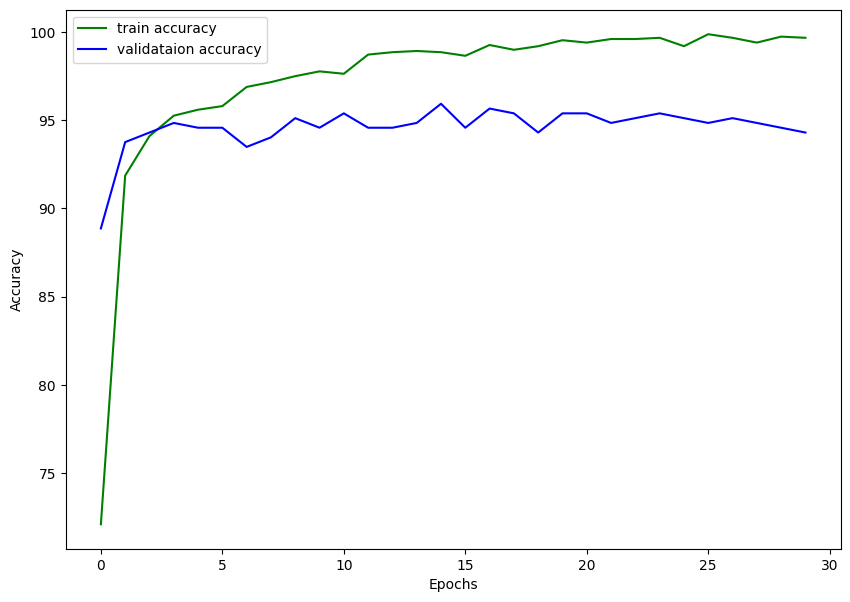

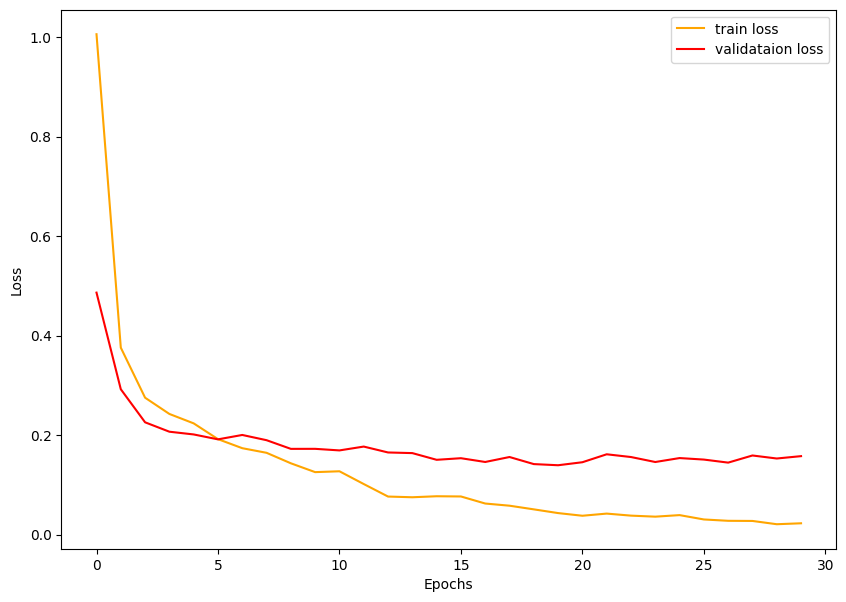

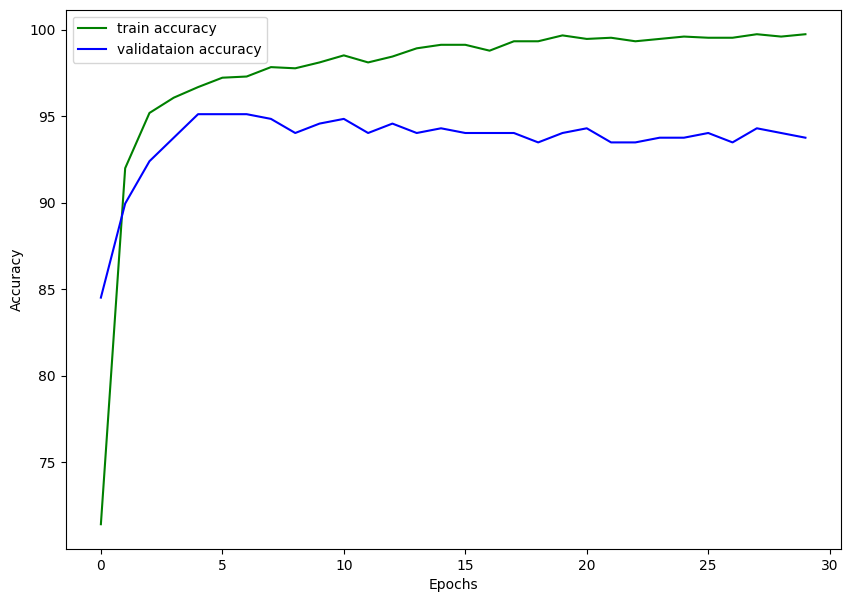

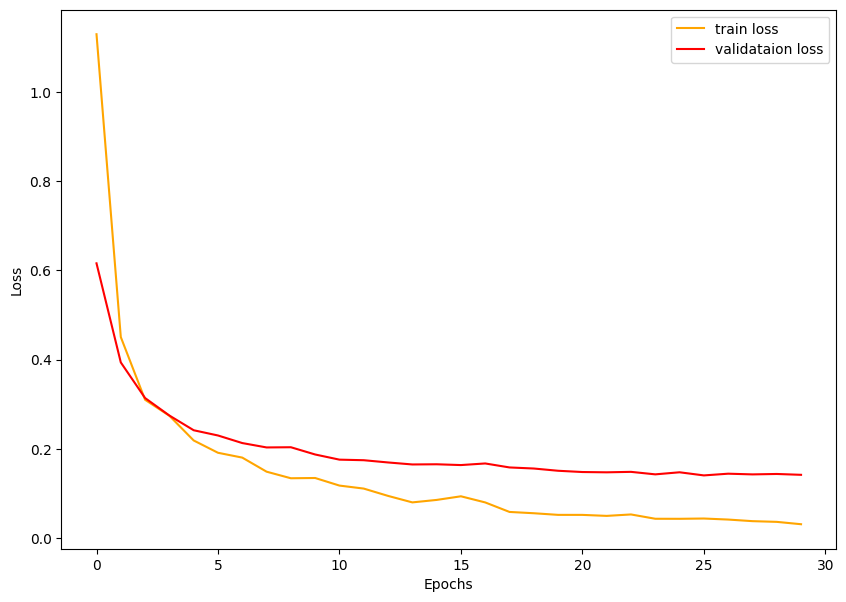

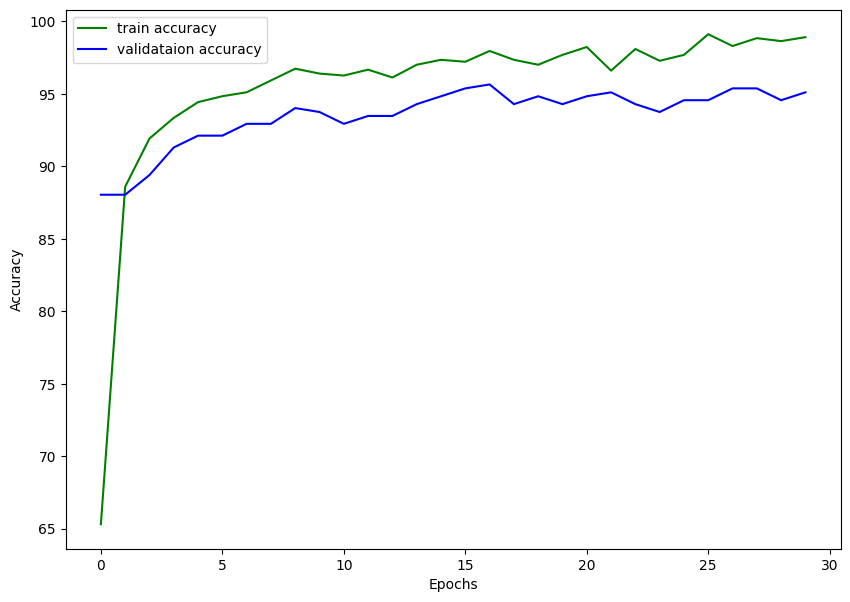

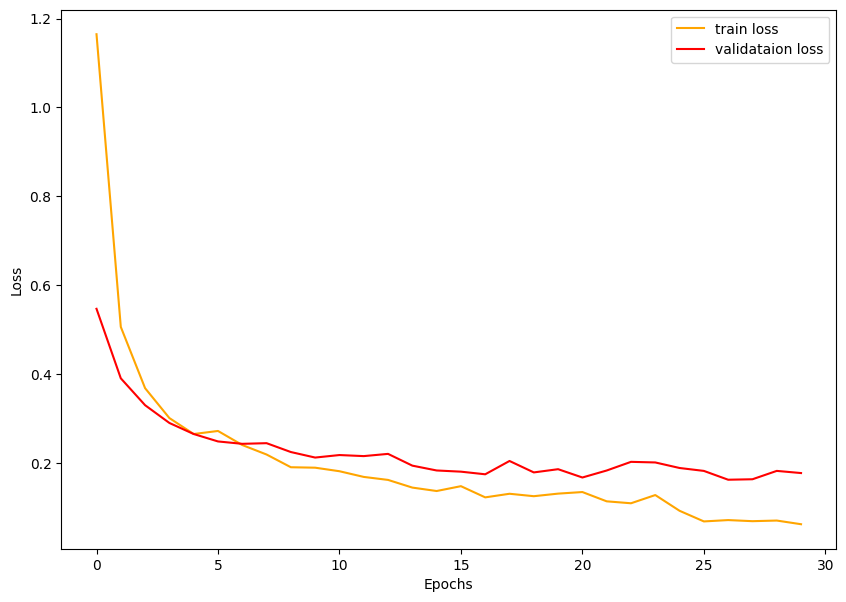

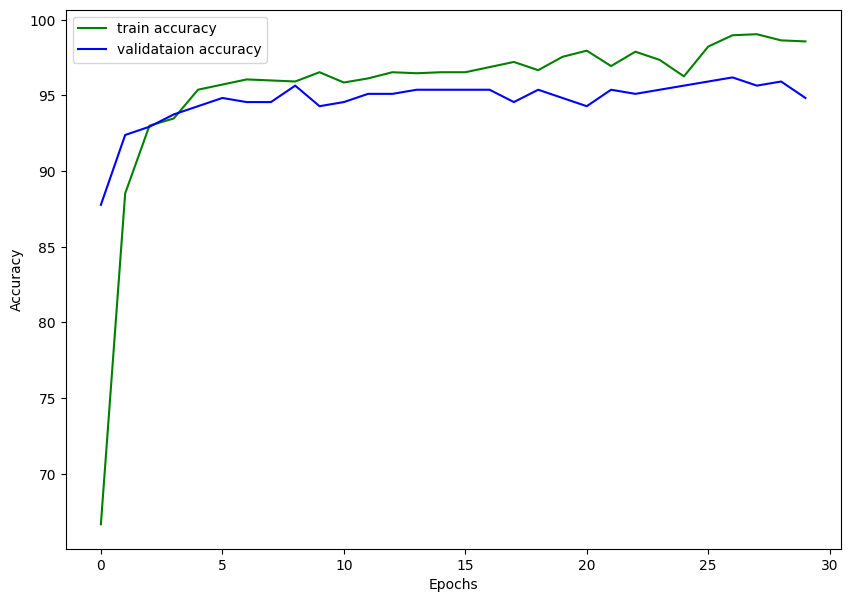

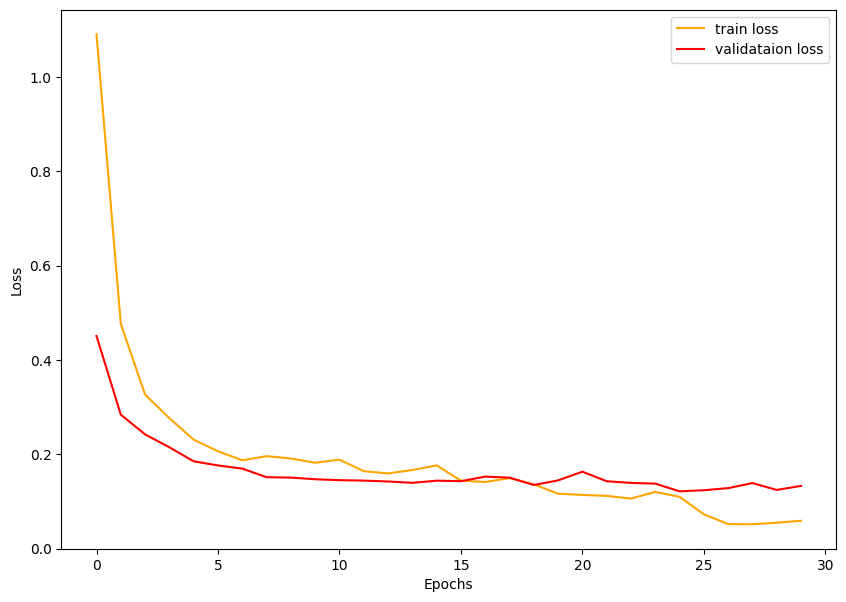

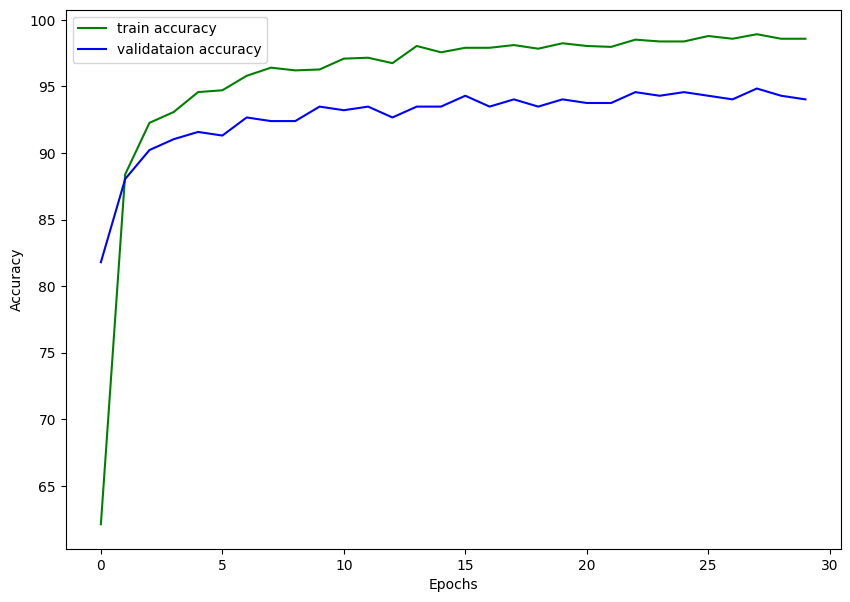

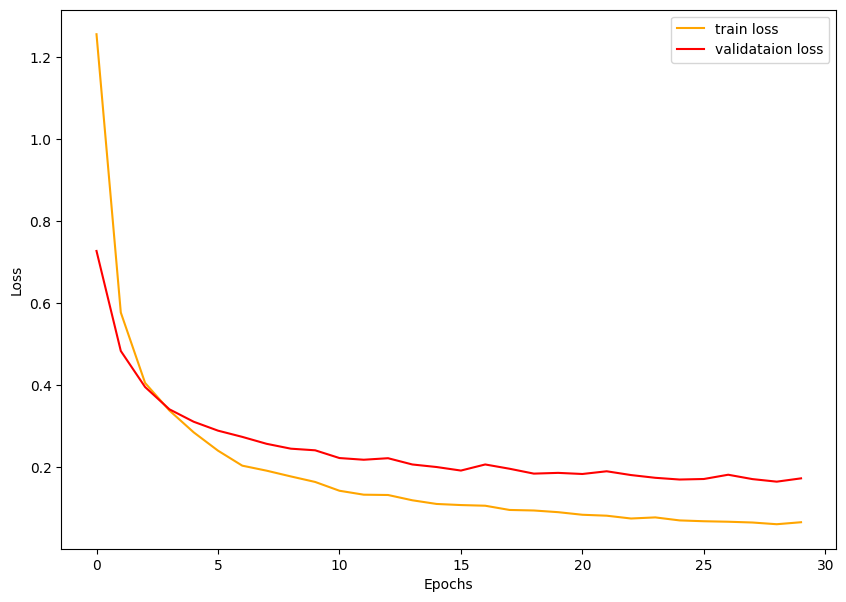

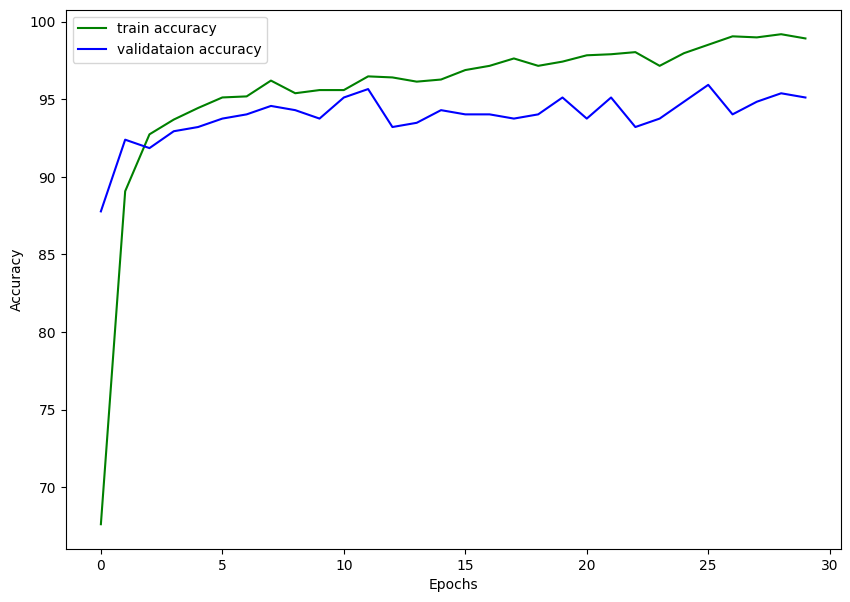

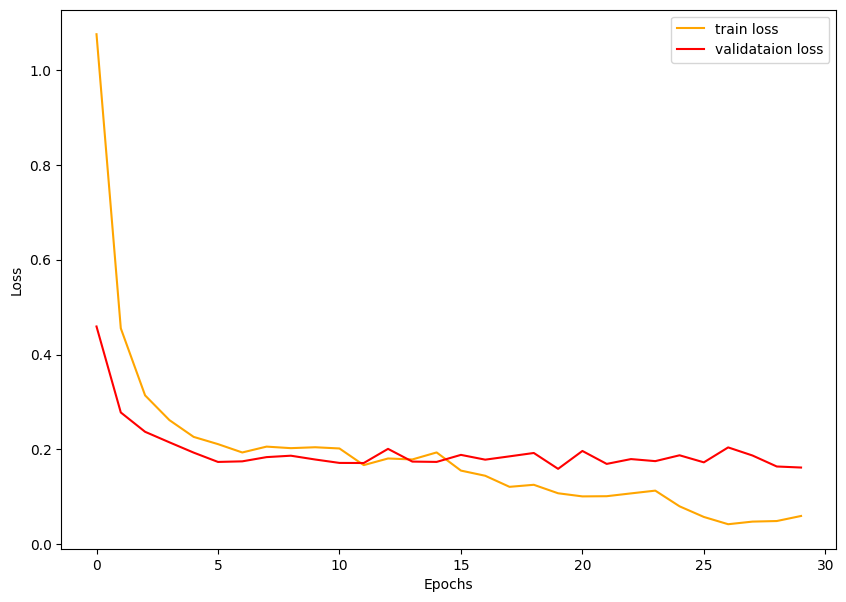

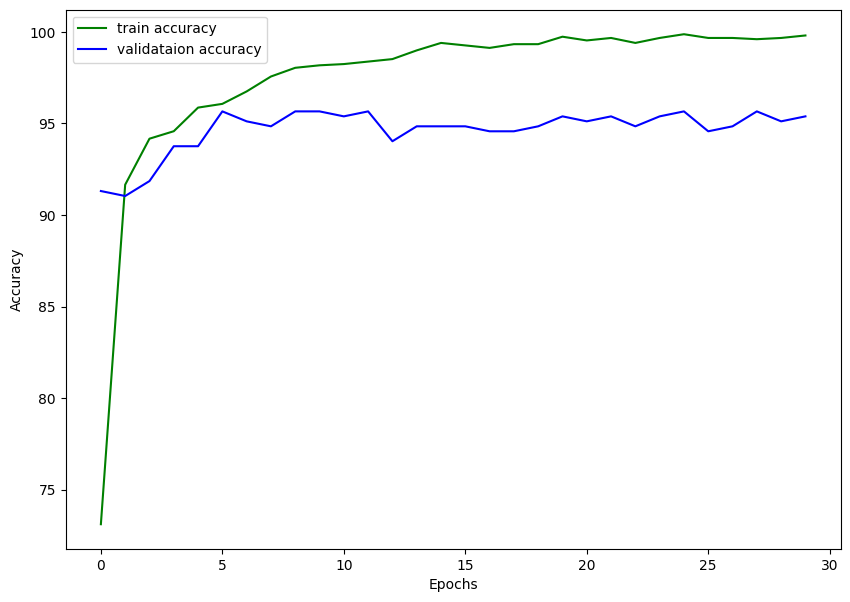

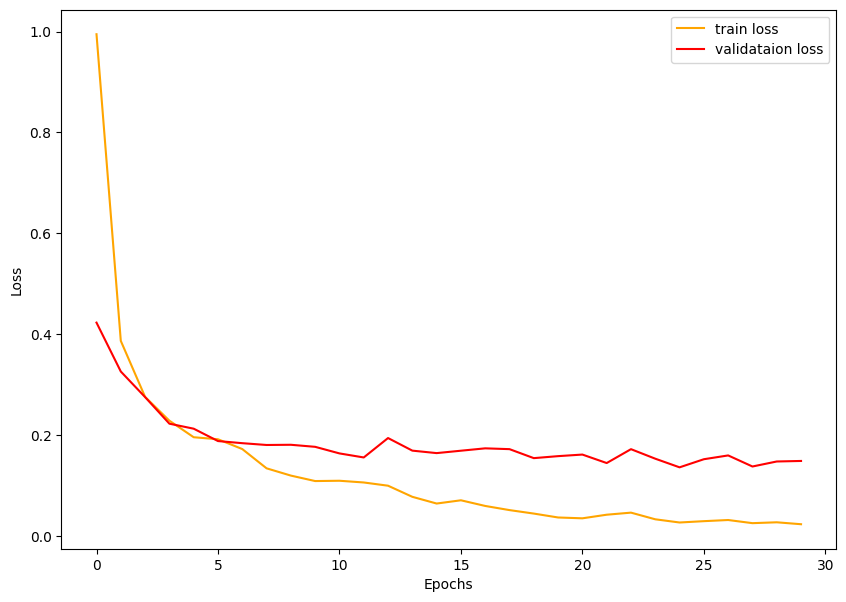

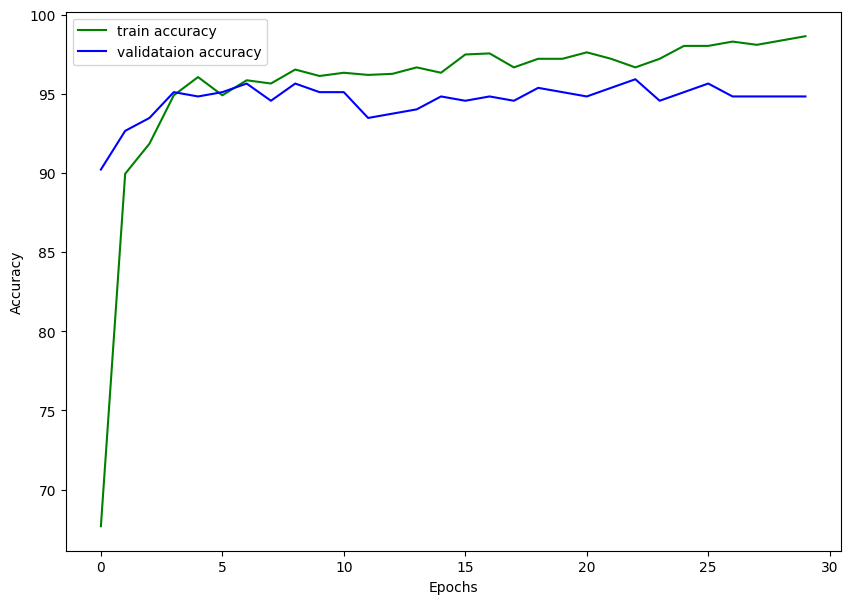

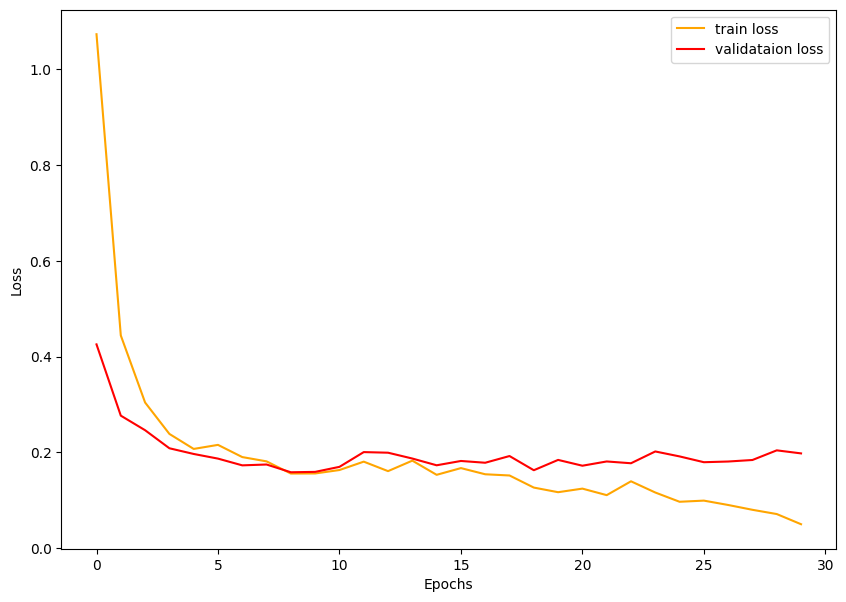

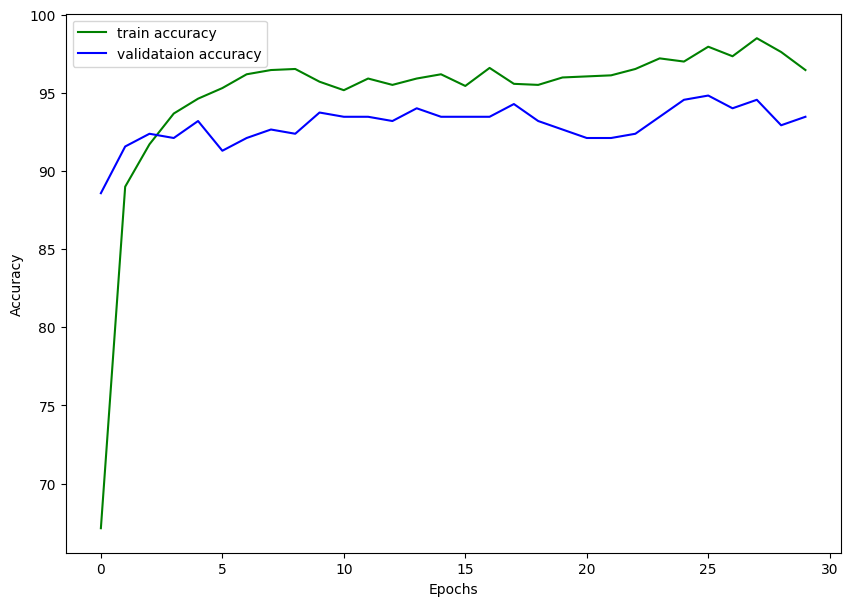

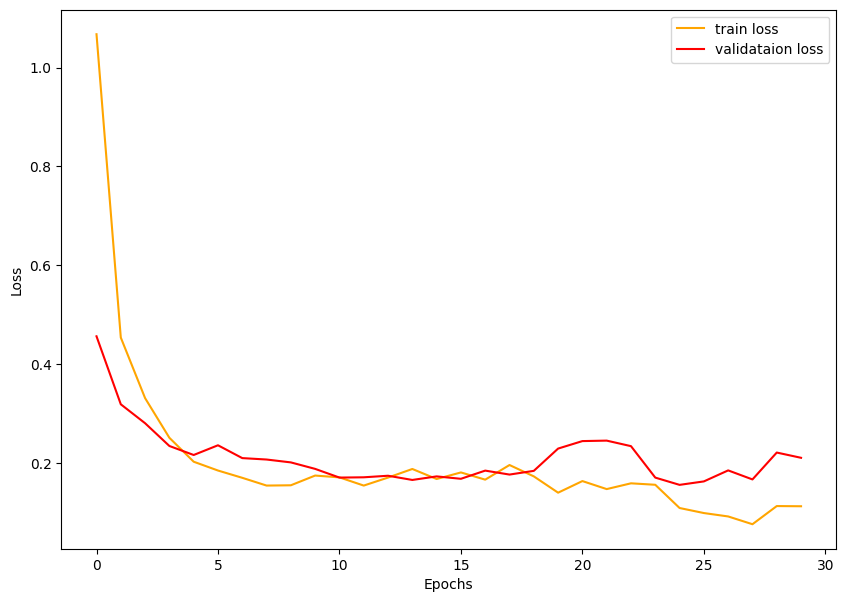

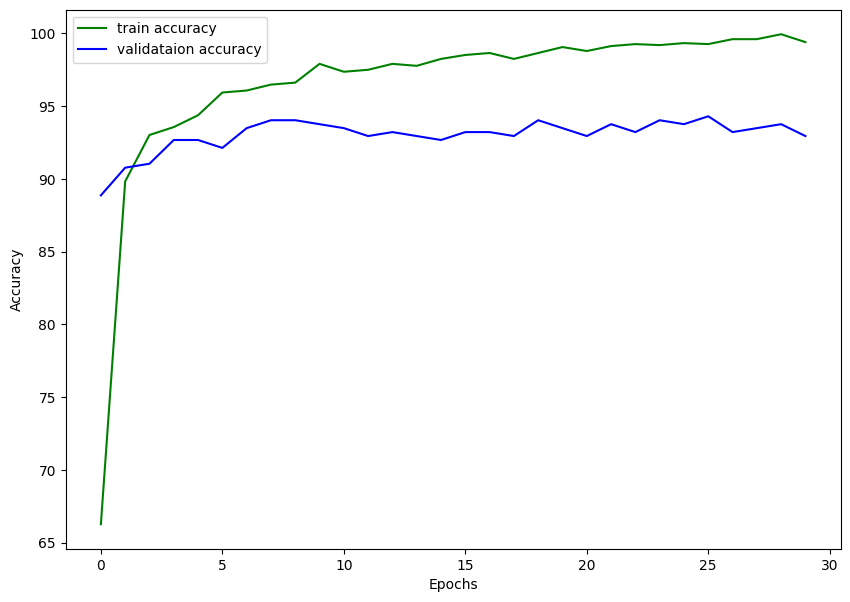

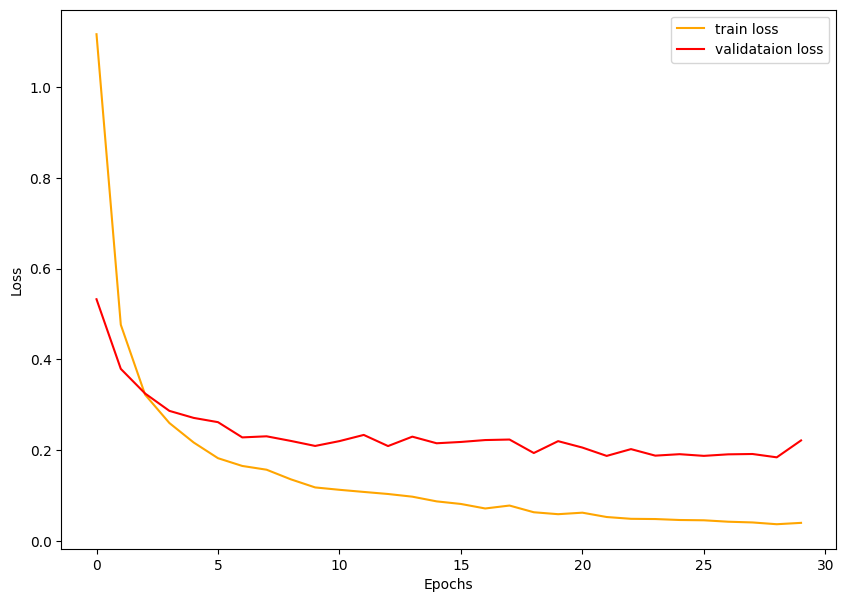

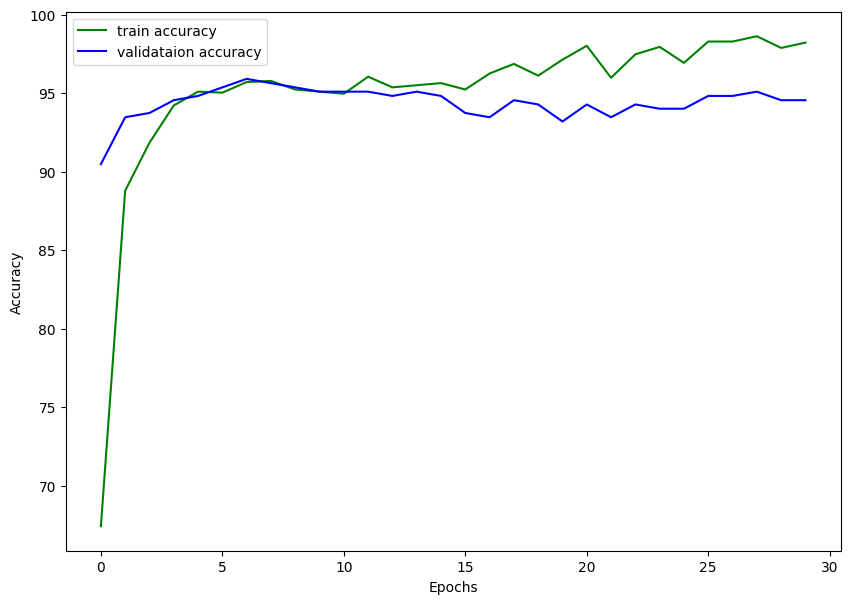

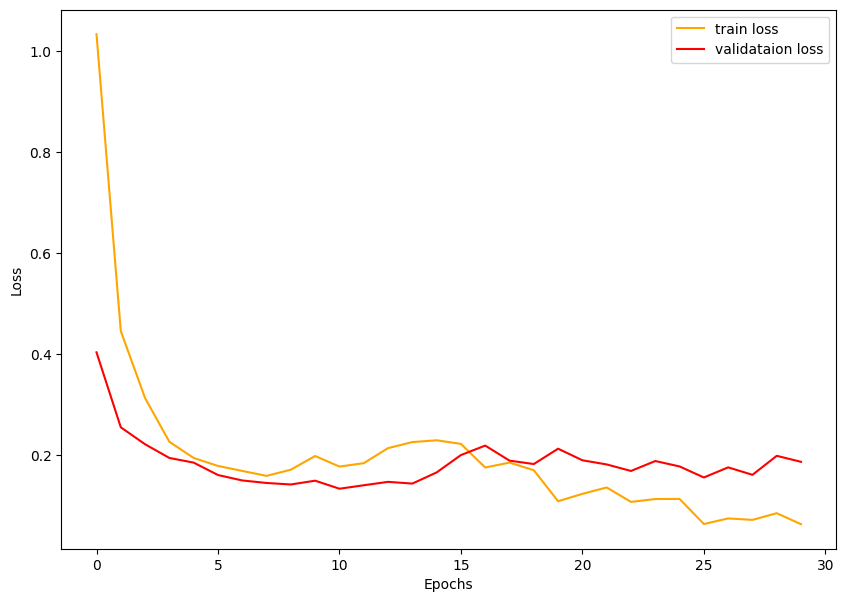

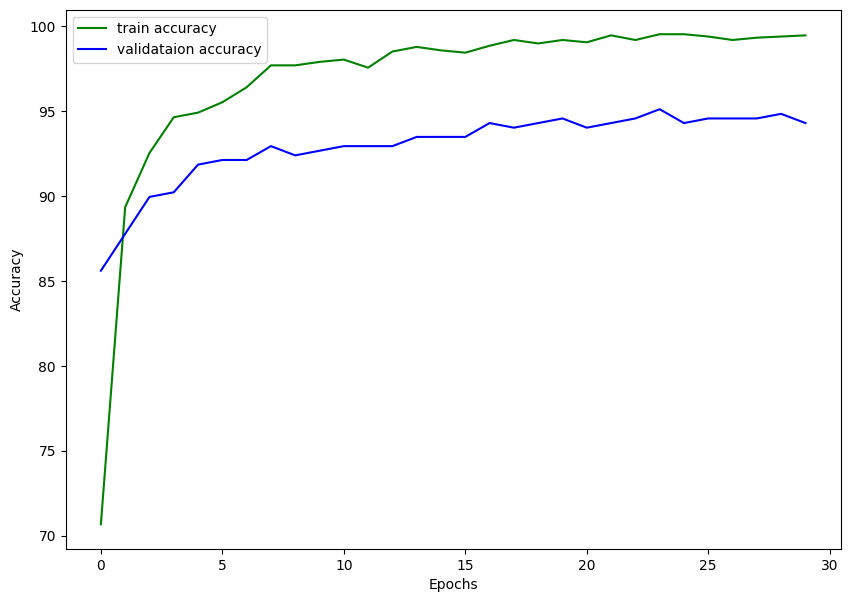

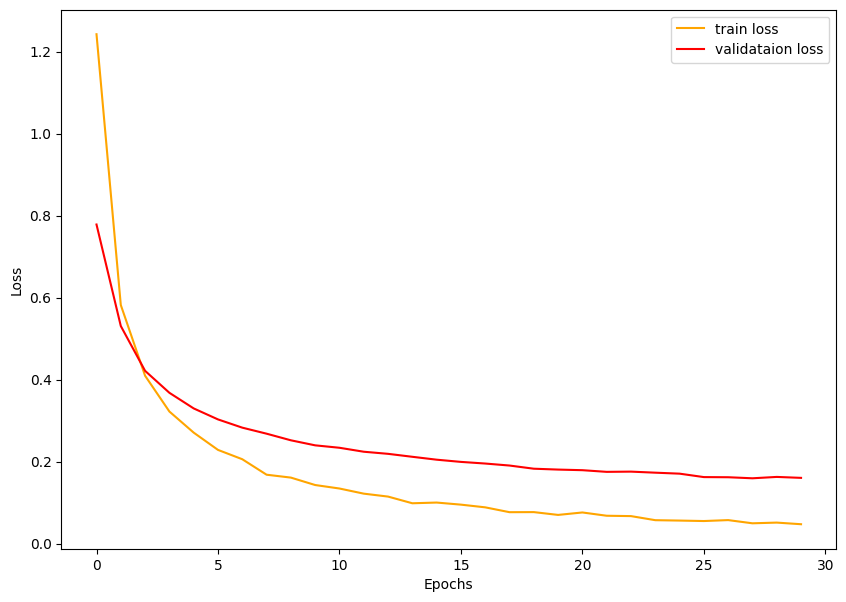

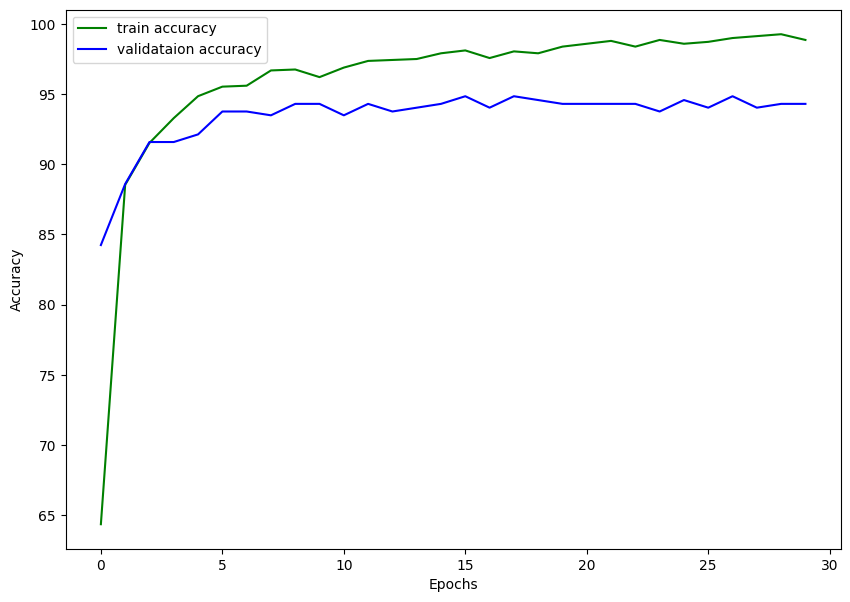

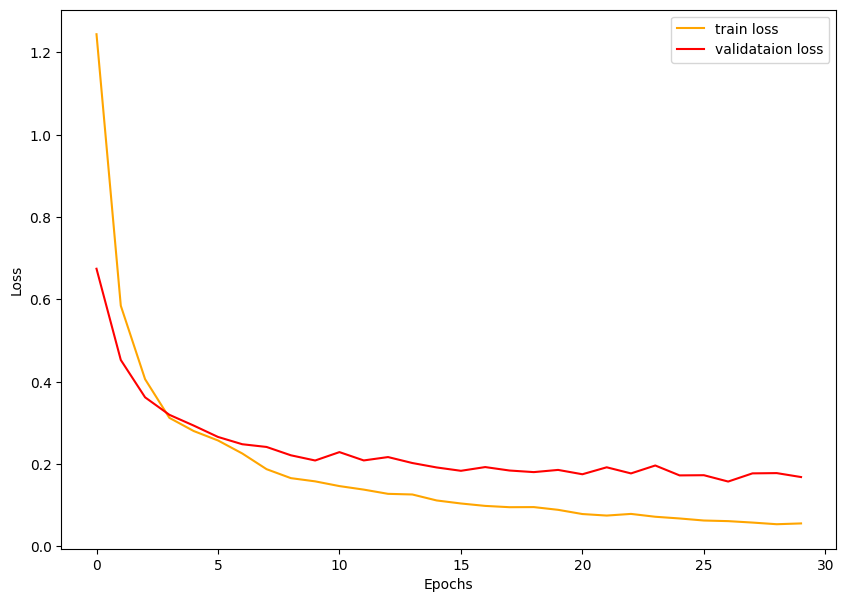

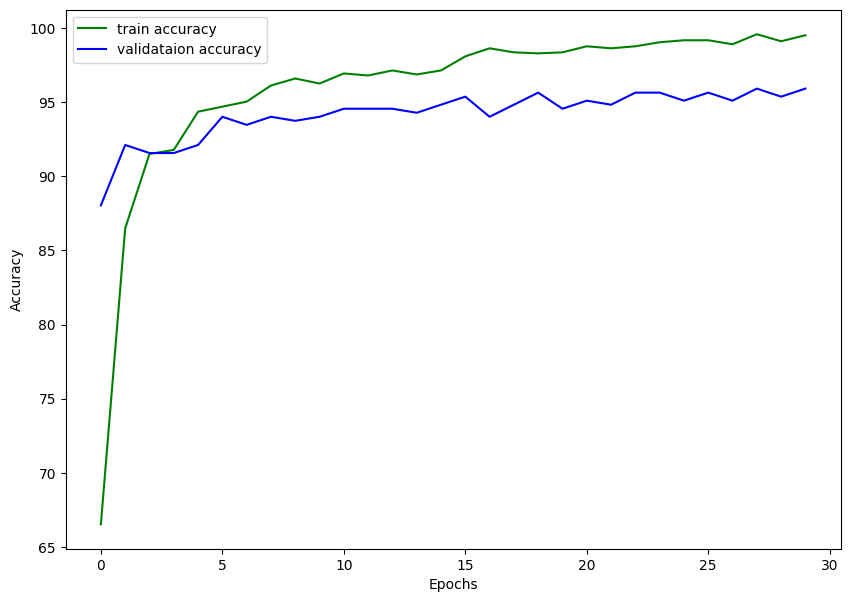

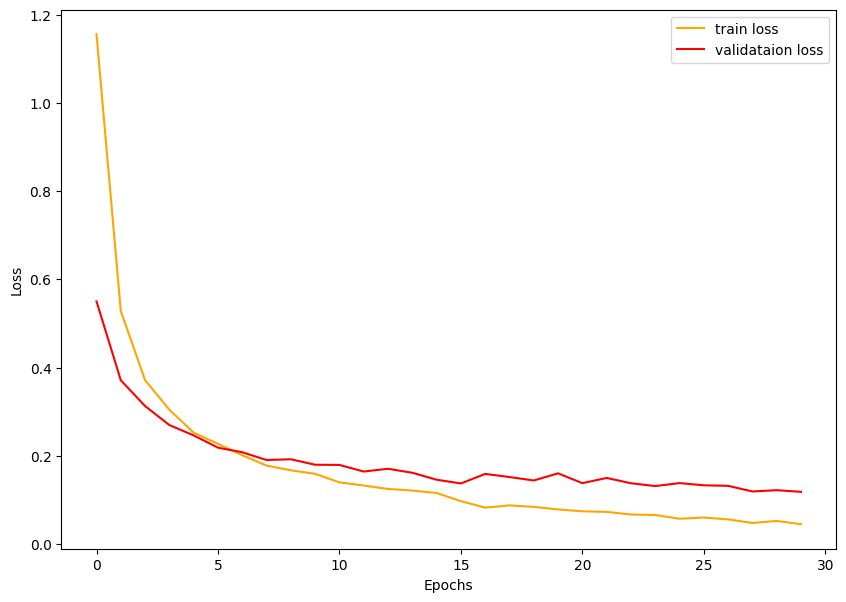

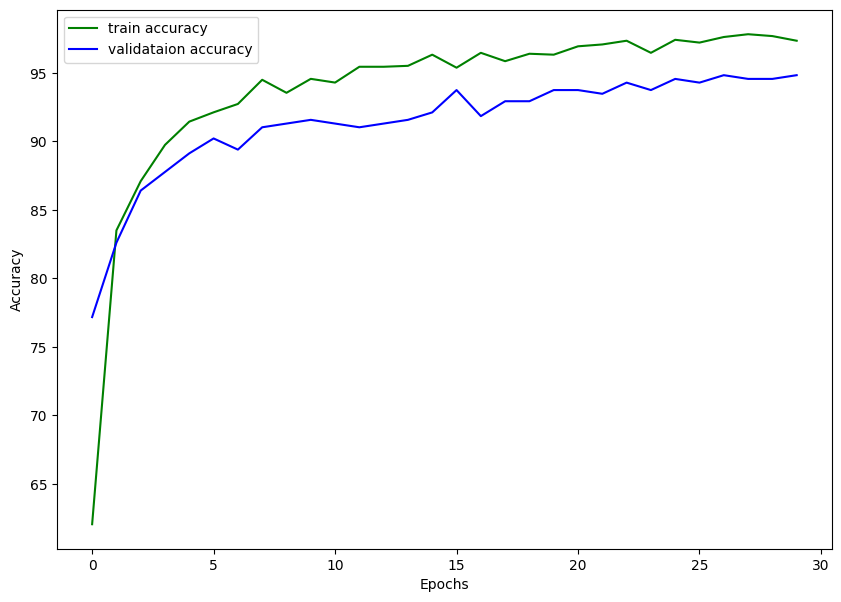

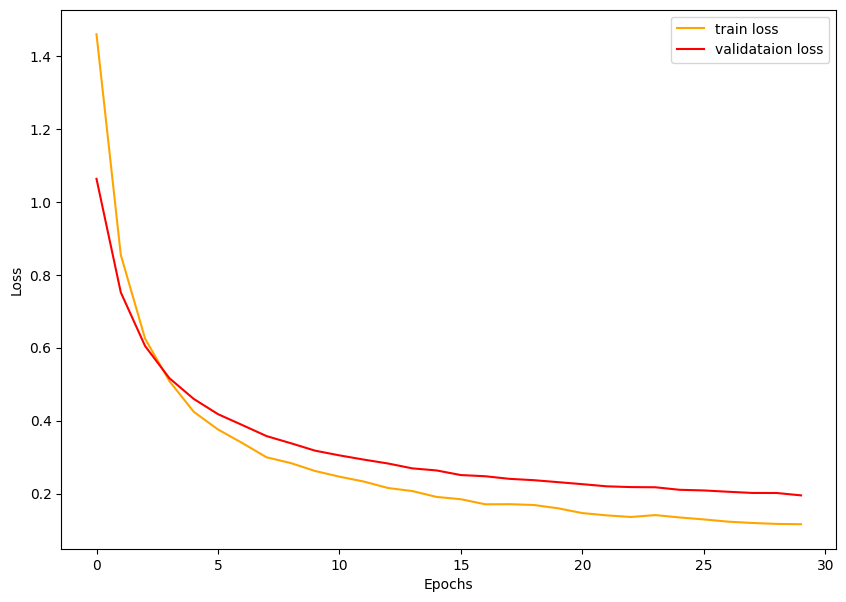

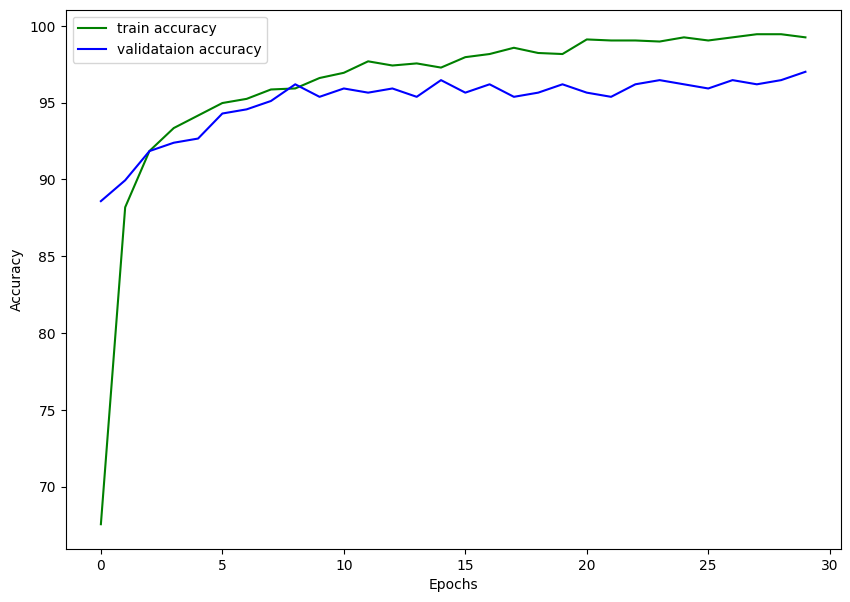

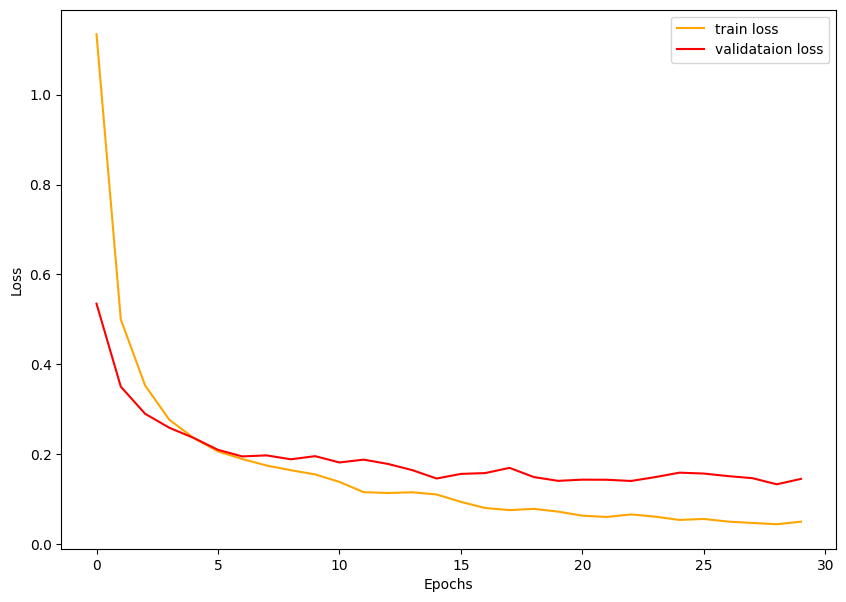

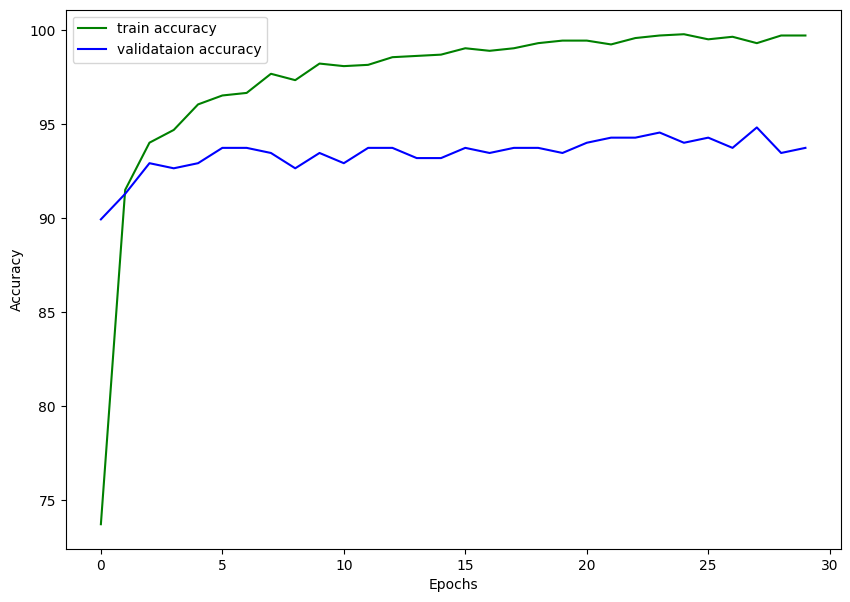

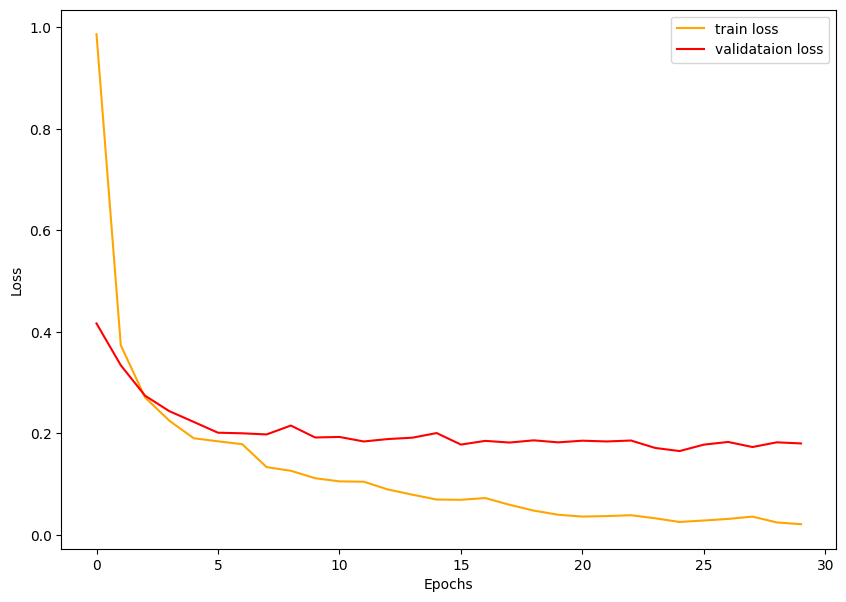

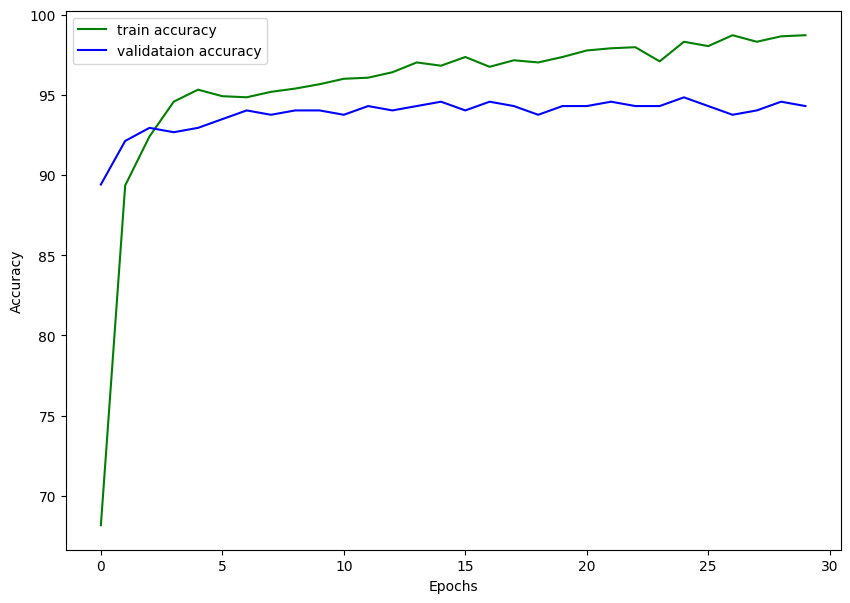

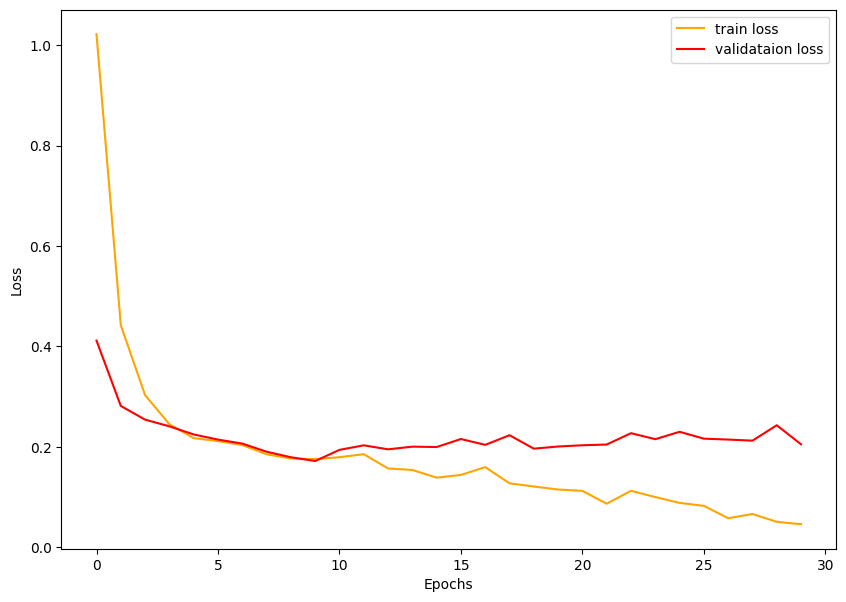

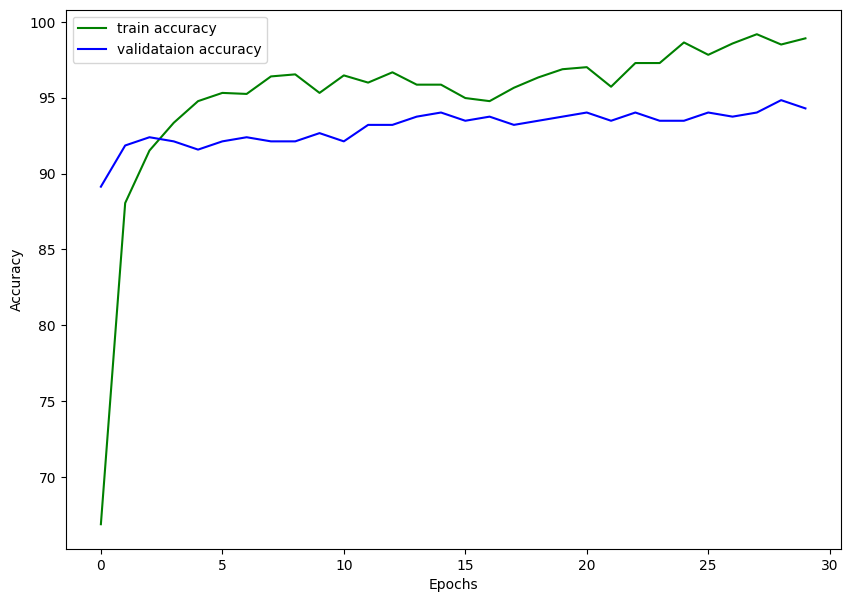

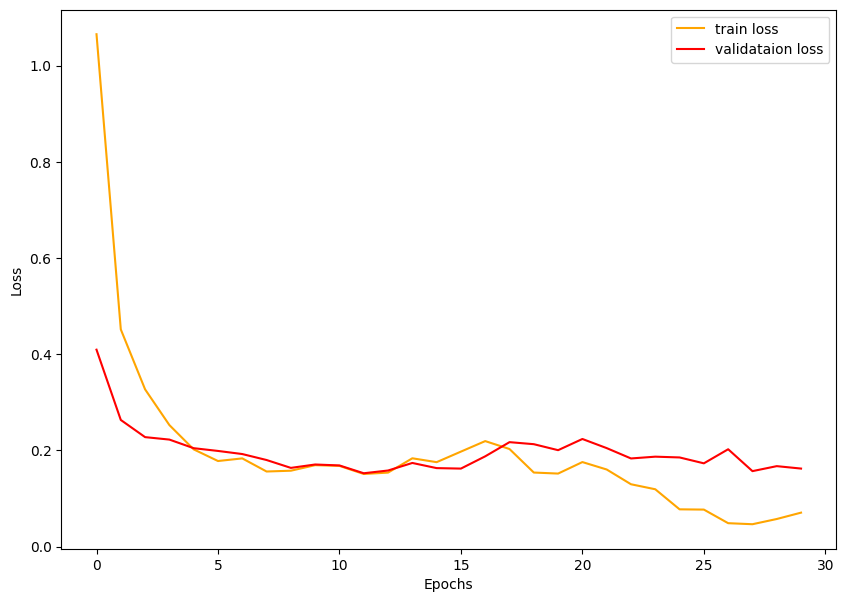

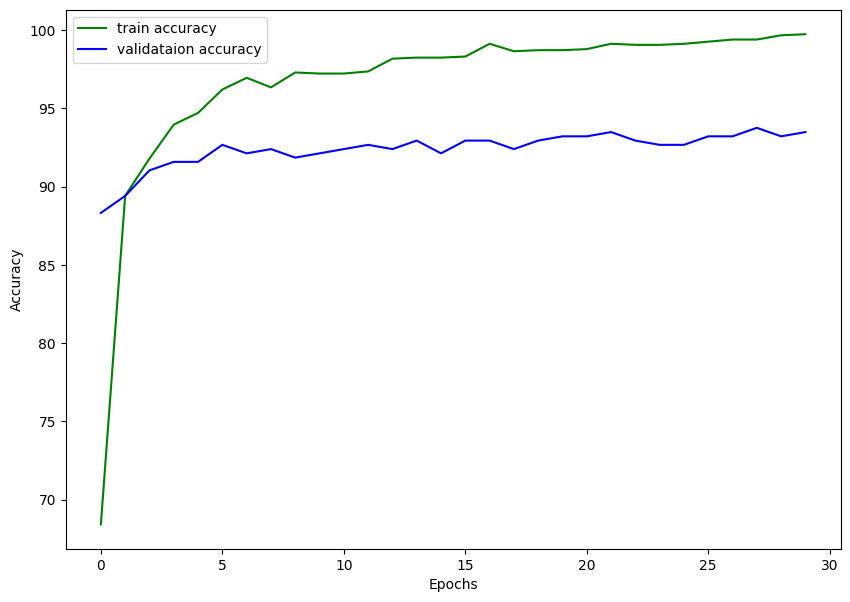

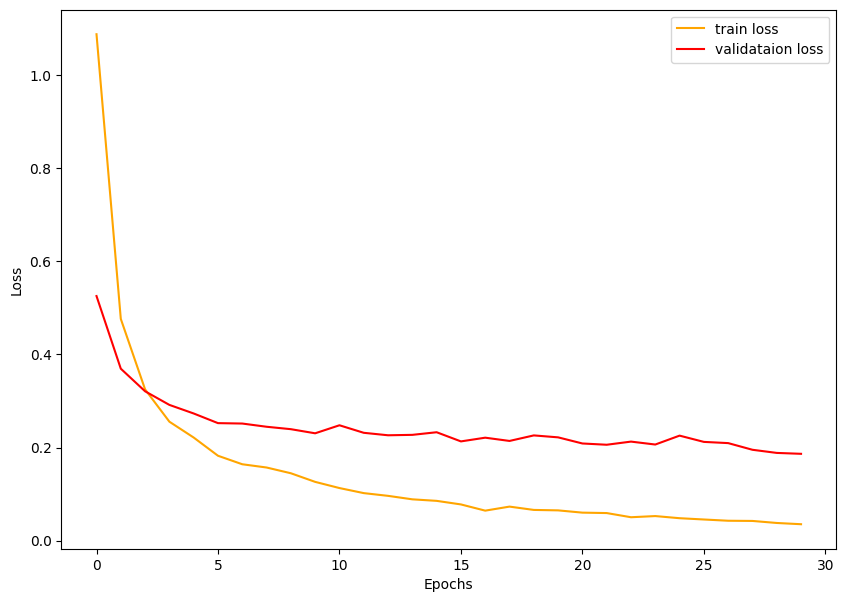

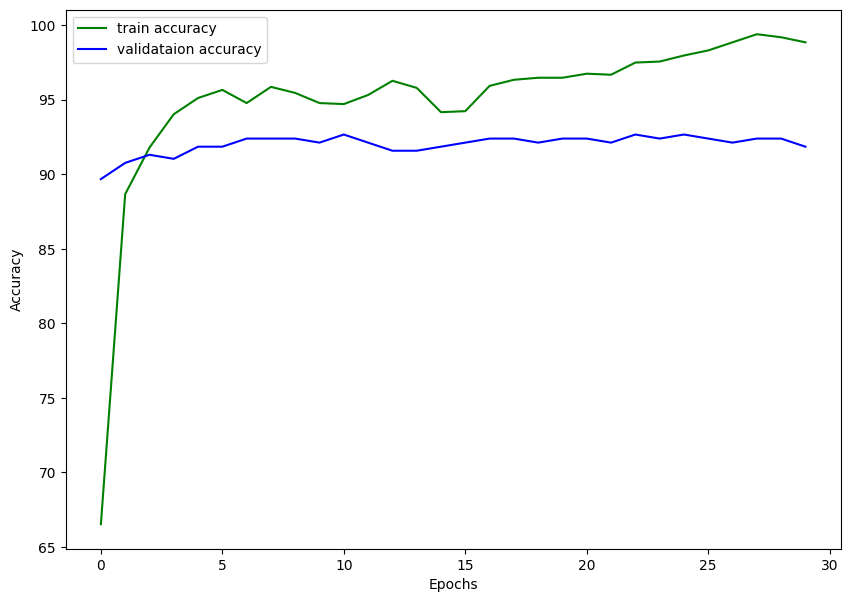

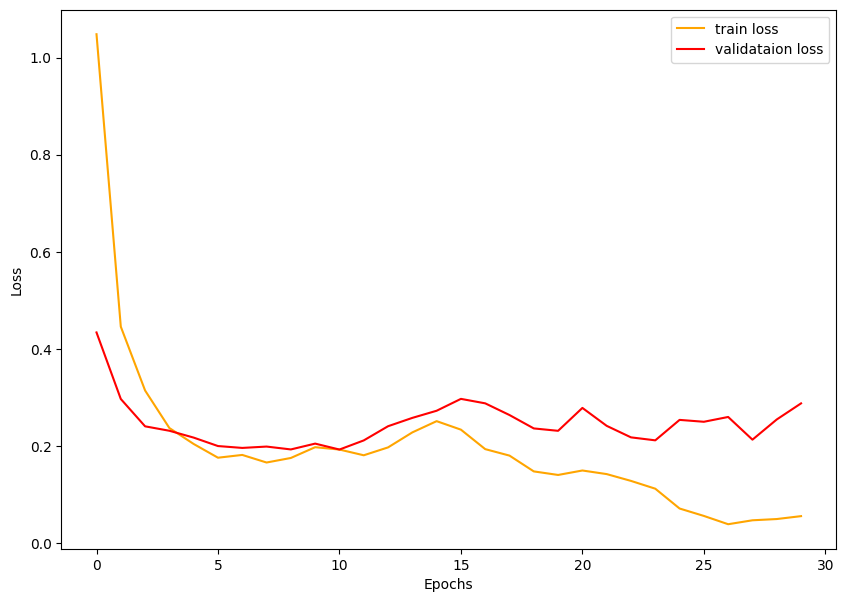

In [100]:
for modelR in models :
    for modelV in models :
        save_file = f'model_recto_{modelR["model_name"]}_model_verso_{modelV["model_name"]}_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth'
        if save_file not in os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/outputs'):
            model_config = {'learning_rate' : 0.001,
                          "epochs" : 30,
                          "pretrained":True,
                          "fine_tune":False,
                            "model_recto":modelR,
                            "model_verso":modelV,
                         }
            trainer = TrainMultiInputModel(model_config,data_config)
            trainer.train_and_validate()

In [ ]:
y_obs = []
for i, (recto,verso) in tqdm(enumerate(trainer.testRectoloader), total=len(trainer.testVersoloader)):
        counter += 1
        image_recto, labels = recto
        y_obs.append(labels)
y_obs = [item for sublist in y_obs for item in sublist]

In [ ]:
import os
all_models_weight = [f for f os.listdir('/home/onyxia/work/pfe-deep-learning-maladies-plantes/multi_vue_pytorch/outputs') if f.endswith(".pth")]
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
all_outputs = []
for modelR in models :
    for modelV in models :
        temp = {}
        model_config = {'learning_rate' : 0.001,
                      "epochs" : 30,
                      "pretrained":True,
                      "fine_tune":False,
                        "model_recto":modelR,
                        "model_verso":modelV,
                     }
        trainer = TrainMultiInputModel(model_config,data_config)
        model_recto = modelR
        model_verso =   modelV           
        model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=False, num_classes=7)
        checkpoint = torch.load(f'{trainer.main_path}/outputs/model_recto_{modelR.name}_model_verso_{modelV.name}_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False.pth', map_location="cuda")
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(trainer.device)
        trainer.model = model
        preds, probs = trainer.predict(trainer.testRectoloader,trainer.testRectoloader)
        {"model_name" : model.name,
         "pred" : preds,
         "probs" : probs,
         "accuracy" : accuracy_score(y_obs,preds),
         "balanced_accuracy" : balanced_accuracy_score(y_obs,preds),
         "nb_trainable_parameters" : sum(
            p.numel() for p in self.model.parameters() if p.requires_grad),
         "nb_parameters" : sum(
            p.numel() for p in self.model.parameters())
        }